# A study of the controls of the temporal variation of the biogeochemical functional groups of phytoplankton

# First, load libraries

In [1]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import netcdf_tools
import numpy as np
import os
import pandas as pd
import pathlib
import scipy
import scipy.interpolate
import scipy.signal
import shutil
import TaylorDiagramMBG
import vstats

plt.close("all")

In [2]:
################################################################################
pd.set_option('display.max_rows', None)

# Select year

In [3]:
years=range(1,11)
nbyears=len(years)
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
first_year366=np.arange(0,366) # first year for heatmaps

# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m)

it corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [4]:
gridfile='grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m)

In [5]:
RC=netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m)

In [6]:
RF=netcdf_tools.read_netcdf(gridfile,'RF')

# Forcing field of ice

In [7]:
ice=np.fromfile('../../gud_1d_35+16/input_noradtrans/input/siarea.nemo.2016.365.32bits.bin',
                dtype='>f')

# Observations of ice

Create directory validation if it doesn't exit.

In [8]:
pathlib.Path("validation").mkdir(parents=True, exist_ok=True)

Breakup was on 18 July 2016 (Oziel et al., 2019).

In [9]:
obsice=np.empty(365)
obsice[:]=np.NaN
obsice[0:199]=1
obsice[199]=0

Day of *in situ* sea ice breakup:

In [10]:
iT15_start_obs=next(i for i,v in enumerate(obsice) if v < 0.15)

# Observations of biogeochemical functional groups

## Observations of biogeochemical functional groups: load dataset

The dataset is available from https://www.seanoe.org/data/00487/59892/ : Photosynthetic picoeukaryotes (abundance) & Phytoplankton measured by Imaging FlowCytobot. The principal investigators were Joannie Ferland, Pierre-Luc Grondin and Marcel Babin.

Reference:
Massicotte, P., Amiraux, R., Amyot, M.-P., Archambault, P., Ardyna, M., Arnaud, L., Artigue, L., Aubry, C., Ayotte, P., Bécu, G., Bélanger, S., Benner, R., Bittig, H. C., Bricaud, A., Brossier, É., Bruyant, F., Chauvaud, L., Christiansen-Stowe, D., Claustre, H., Cornet-Barthaux, V., Coupel, P., Cox, C., Delaforge, A., Dezutter, T., Dimier, C., Domine, F., Dufour, F., Dufresne, C., Dumont, D., Ehn, J., Else, B., Ferland, J., Forget, M.-H., Fortier, L., Galí, M., Galindo, V., Gallinari, M., Garcia, N., Gérikas Ribeiro, C., Gourdal, M., Gourvil, P., Goyens, C., Grondin, P.-L., Guillot, P., Guilmette, C., Houssais, M.-N., Joux, F., Lacour, L., Lacour, T., Lafond, A., Lagunas, J., Lalande, C., Laliberté, J., Lambert-Girard, S., Larivière, J., Lavaud, J., LeBaron, A., Leblanc, K., Le Gall, F., Legras, J., Lemire, M., Levasseur, M., Leymarie, E., Leynaert, A., Lopes dos Santos, A., Lourenço, A., Mah, D., Marec, C., Marie, D., Martin, N., Marty, C., Marty, S., Massé, G., Matsuoka, A., Matthes, L., Moriceau, B., Muller, P.-E., Mundy, C.-J., Neukermans, G., Oziel, L., Panagiotopoulos, C., Pangrazi, J.-J., Picard, G., Picheral, M., Pinczon du Sel, F., Pogorzelec, N., Probert, I., Quéguiner, B., Raimbault, P., Ras, J., Rehm, E., Reimer, E., Rontani, J.-F., Rysgaard, S., Saint-Béat, B., Sampei, M., Sansoulet, J., Schmechtig, C., Schmidt, S., Sempéré, R., Sévigny, C., Shen, Y., Tragin, M., Tremblay, J.-É., Vaulot, D., Verin, G., Vivier, F., Vladoiu, A., Whitehead, J., and Babin, M.: Green Edge ice camp campaigns: understanding the processes controlling the under-ice Arctic phytoplankton spring bloom, Earth Syst. Sci. Data, 12, 151–176, https://doi.org/10.5194/essd-12-151-2020, 2020.

In [11]:
def load_groups():
    fname='../../obs/66408.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_name': 'string',
                'sample_type': 'category',
                'depth_m': np.float32,
                'sample_source': 'category',
                'snow_thickness': 'category',
                'ml_analyzed': np.float32,
                'dilution_factor': np.float32,
                'taxonomy': 'category',
                'carbon_estimate_mg_c_m3': np.float32,
                'nb_images_img_ml': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth'
            )
        )
    )
    df['depth']=-df['depth'] # negative depths
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [12]:
groups_df=load_groups()

## Cases of depth profiles

In [13]:
all_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                 &  (groups_df.sample_type=='water')]
by_doy_depth=all_df.groupby(['doy','depth'])

In [14]:
# by_doy_depth.first().reset_index()[['doy','depth']]

In [15]:
#doy: 120
depths_case1 =np.array([      -1.5, -5])
weights_case1=np.array([       3.25, 96.75])
#doy: 123
depths_case2 =np.array([      -1.5, -5,   -10,   -20,    -40])
weights_case2=np.array([       3.25, 4.25,  7.5,  15,     70])
#doy: 125
depths_case3 =np.array([0,          -5,   -10,   -20])
weights_case3=np.array([2.5,         5,     7.5,  85])
#doy: 127,130,134,141,144,153,155,158,160,162,165,167,169,172,174,176
depths_case4 =np.array([0,    -1.5, -5,   -10,   -20,    -40])
weights_case4=np.array([0.75,  2.5,  4.25,  7.5,  15,     70])
#doy: 132
depths_case5 =np.array([0,    -1.5, -5,   -10,           -40])
weights_case5=np.array([0.75,  2.5,  4.25, 17.5,          75])
#doy: 137,139
depths_case6 =np.array([0,    -1.5, -5,   -10,   -20])
weights_case6=np.array([0.75,  2.5,  4.25,  7.5,  85])
#doy: 179,181,183,186,188,190
depths_case7 =np.array([0,    -1.5,       -10,   -20,-30,    -60])
weights_case7=np.array([0.75,  5,           9.25, 10, 20,     55])
#doy: 193,195,200
depths_case8 =np.array([    -1.5,        -10,   -20,-30,     -60,  -75])
weights_case8=np.array([     5.75,         9.25, 10, 20,      22.5, 32.5])
#doy: 197,182
depths_case9 =np.array([    -1.5,       -10,   -20,-30,  -45,-60])
weights_case9=np.array([     5.75,        9.25, 10, 12.5, 15, 47.5])

## Observations of biogeochemical functional groups: diatoms

We select the observations of diatoms at the Green Edge Sea Ice Camp in 2016.

In [16]:
diatomsnotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Attheya') \
    | (groups_df.taxonomy=='Centric diatoms') \
    | (groups_df.taxonomy=='Centric diatoms chains') \
    | (groups_df.taxonomy=='Chaetoceros') \
    | (groups_df.taxonomy=='Cylindrotheca closterium') \
    | (groups_df.taxonomy=='Entomoneis') \
    | (groups_df.taxonomy=='Eucampia') \
    | (groups_df.taxonomy=='Fragilariopsis') \
    | (groups_df.taxonomy=='Gyro_Pleurosigma') \
    | (groups_df.taxonomy=='Licmophora') \
    | (groups_df.taxonomy=='Melosira') \
    | (groups_df.taxonomy=='Navicula') \
    | (groups_df.taxonomy=='Navicula pelagica') \
    | (groups_df.taxonomy=='Navicula septentrionalis') \
    | (groups_df.taxonomy=='Nitzschia frigida') \
    | (groups_df.taxonomy=='Pennate diatoms') \
    | (groups_df.taxonomy=='Pennate diatoms chains') \
    | (groups_df.taxonomy=='Porosira') \
    | (groups_df.taxonomy=='Pseudo-nitzschia') \
    | (groups_df.taxonomy=='Rhizosolenia') \
    | (groups_df.taxonomy=='Thalassiosira') \
    | (groups_df.taxonomy=='Thalassiosira nordenskioeldii') \
) \
                              ]

In [17]:
# diatomsnotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [18]:
diatoms_df=diatomsnotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
diatomsnoobs=diatoms_df[diatoms_df.carbon_estimate_mg_c_m3==0.0]
diatomsobs_df=diatoms_df[diatoms_df.carbon_estimate_mg_c_m3!=0.0]

In [19]:
# diatoms_df

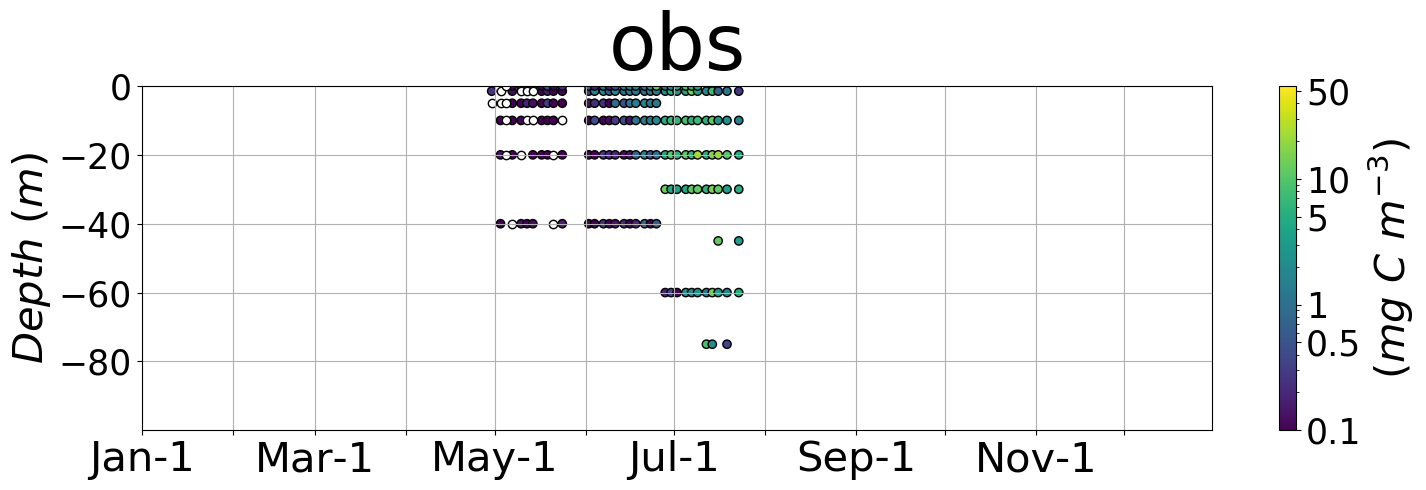

In [20]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(diatomsobs_df['doy']-1,
                  diatomsobs_df['depth'],
                  c=diatomsobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(diatomsnoobs['doy']-1,
                  diatomsnoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.diatoms.m3.png')

In [21]:
plt.close('all')

In [22]:
nT=365
array1d_iT_obsdiatomvint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdiatomvint=np.NaN
    obsdiatom=[]
    doy=iT+1
    obsdiatom_oneday_df=diatoms_df[['depth','carbon_estimate_mg_c_m3']][(diatoms_df.doy==doy)]
    depths=obsdiatom_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obsdiatomtempo \
#             =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
#             assert obsdiatomtempo.size==1
#             obsdiatomtempo=obsdiatomtempo.iat[0]
#             obsdiatom.append(obsdiatomtempo)
#         obsdiatomvint=np.dot(obsdiatom,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obsdiatomtempo \
            =obsdiatom_oneday_df['carbon_estimate_mg_c_m3'][(obsdiatom_oneday_df.depth==depth)]
            assert obsdiatomtempo.size==1
            obsdiatomtempo=obsdiatomtempo.iat[0]
            obsdiatom.append(obsdiatomtempo)
        obsdiatomvint=np.dot(obsdiatom,weights_case9)
    array1d_iT_obsdiatomvint[iT]=obsdiatomvint

In [23]:
obsdiatomvinttotal=np.nansum(array1d_iT_obsdiatomvint)
obsdiatomvinttotal # mg C m^-2

5937.755887902342

## Observations of biogeochemical functional groups: dinoflagellates

We select the observations of dinoflagellates at the Green Edge Sea Ice Camp in 2016.

In [24]:
dinonotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy=='Cryptophytes') \
    | (groups_df.taxonomy=='Dinoflagellates') \
    | (groups_df.taxonomy=='Euglenozoa') \
    | (groups_df.taxonomy=='Neoceratium') \
    | (groups_df.taxonomy=='Peridiniella catenata') \
    | (groups_df.taxonomy=='Polarella glacialis')
) \
                              ]

In [25]:
# dinonotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [26]:
dino_df=dinonotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
dinonoobs=dino_df[dino_df.carbon_estimate_mg_c_m3==0.0]
dinoobs_df=dino_df[dino_df.carbon_estimate_mg_c_m3!=0.0]

In [27]:
# dinoobs_df

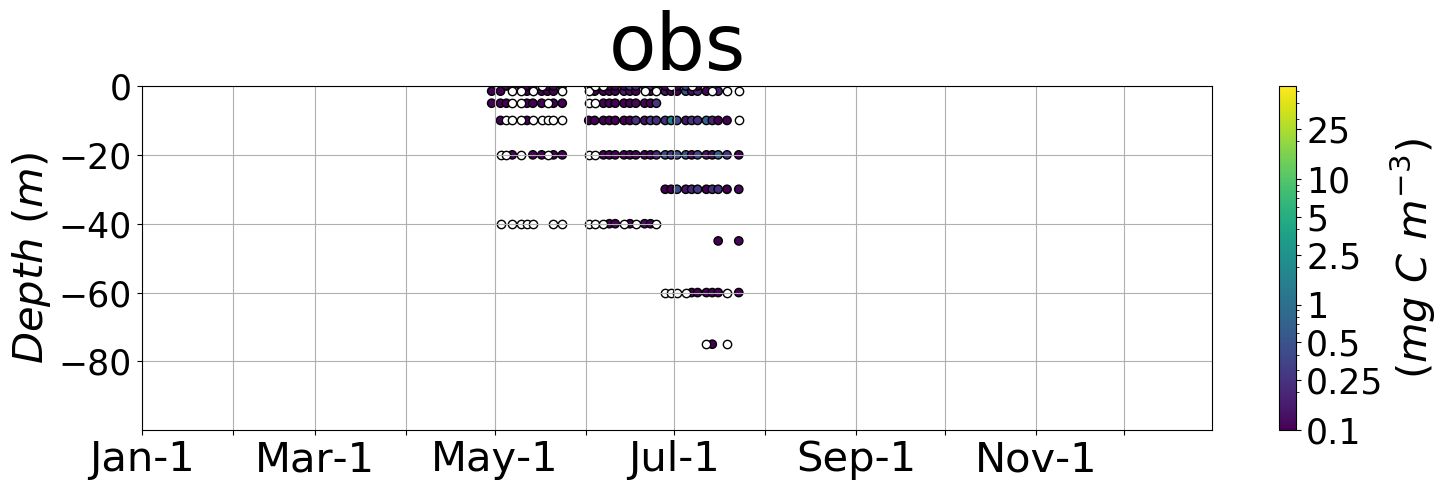

In [28]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(dinoobs_df['doy']-1,
                  dinoobs_df['depth'],
                  c=dinoobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(dinonoobs['doy']-1,
                  dinonoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.dino.m3.png')

In [29]:
plt.close('all')

In [30]:
nT=365
array1d_iT_obsdinovint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdinovint=np.NaN
    obsdino=[]
    doy=iT+1
    obsdino_oneday_df=dino_df[['depth','carbon_estimate_mg_c_m3']][(dino_df.doy==doy)]
    depths=obsdino_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obsdinotempo \
#             =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
#             assert obsdinotempo.size==1
#             obsdinotempo=obsdinotempo.iat[0]
#             obsdino.append(obsdinotempo)
#         obsdinovint=np.dot(obsdino,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obsdinotempo \
            =obsdino_oneday_df['carbon_estimate_mg_c_m3'][(obsdino_oneday_df.depth==depth)]
            assert obsdinotempo.size==1
            obsdinotempo=obsdinotempo.iat[0]
            obsdino.append(obsdinotempo)
        obsdinovint=np.dot(obsdino,weights_case9)
    array1d_iT_obsdinovint[iT]=obsdinovint

In [31]:
obsdinovinttotal=np.nansum(array1d_iT_obsdinovint)
obsdinovinttotal # mg C m^-2

167.180160171818

## Observations of biogeochemical functional groups: other nanoeukaryotes

We select the observations of phytoplankton other than diatoms, dinoflagellates, diazotrophs and picophytoplankton at the Green Edge Sea Ice Camp in 2016.
They were the group of observed phytoplankton 'other nanoeukaryotes'.

No coccolithophores were observed.

In [32]:
othernotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                               &  (groups_df.sample_type=='water') \
                               & (
    (groups_df.taxonomy==  'Anabaena') \
    | (groups_df.taxonomy=='Ciliates') \
    | (groups_df.taxonomy=='Dictyocha') \
    | (groups_df.taxonomy=='Flagellates') \
    | (groups_df.taxonomy=='Other phytoplankton') \
    | (groups_df.taxonomy=='Phaeocystis')
) \
                              ]

In [33]:
# othernotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [34]:
other_df=othernotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
othernoobs=other_df[other_df.carbon_estimate_mg_c_m3==0.0]
otherobs_df=other_df[other_df.carbon_estimate_mg_c_m3!=0.0]

In [35]:
# otherobs_df

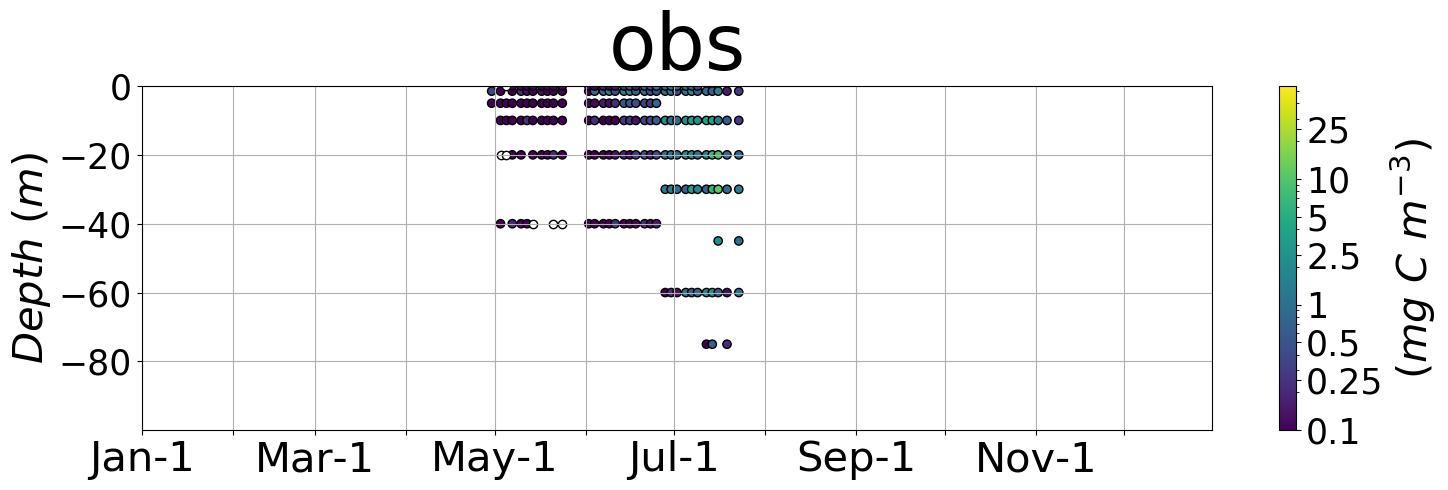

In [36]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(otherobs_df['doy']-1,
                  otherobs_df['depth'],
                  c=otherobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(othernoobs['doy']-1,
                  othernoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.other.m3.png')

In [37]:
plt.close('all')

In [38]:
nT=365
array1d_iT_obsothervint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsothervint=np.NaN
    obsother=[]
    doy=iT+1
    obsother_oneday_df=other_df[['depth','carbon_estimate_mg_c_m3']][(other_df.doy==doy)]
    depths=obsother_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obsothertempo \
#             =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
#             assert obsothertempo.size==1
#             obsothertempo=obsothertempo.iat[0]
#             obsother.append(obsothertempo)
#         obsothervint=np.dot(obsother,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obsothertempo \
            =obsother_oneday_df['carbon_estimate_mg_c_m3'][(obsother_oneday_df.depth==depth)]
            assert obsothertempo.size==1
            obsothertempo=obsothertempo.iat[0]
            obsother.append(obsothertempo)
        obsothervint=np.dot(obsother,weights_case9)
    array1d_iT_obsothervint[iT]=obsothervint

In [39]:
obsothervinttotal=np.nansum(array1d_iT_obsothervint)
obsothervinttotal # mg C m^-2

1689.147183447727

## Observations of biogeochemical functional groups: all

In [40]:
obsallvinttotal=obsdiatomvinttotal+obsdinovinttotal+obsothervinttotal
obsallvinttotal # mg C m^-2

7794.083231521887

## Observations of plankton more difficult to classify

4 plankton observed at the Green Edge Sea Ice Camp in 2016 were more difficult to classify into one of the following groups of the model:  diatoms, (mixotrophic) dinoflagellates, other nanoeukaryotes, diazotrophs or picophytoplankton. Plots of their observations were done to evaluate their abundance in order to estimate if the difficulty to classify them was a problem. If they were not abundant, it was not a problem if they were not classify well.

### Observations of $Anabaena$

In [41]:
anabaenanotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                                &  (groups_df.sample_type=='water') \
                                & (
    (groups_df.taxonomy=='Anabaena') \
) \
                               ]

In [42]:
# anabaenanotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [43]:
anabaena_df=anabaenanotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
anabaenanoobs_df=anabaena_df[anabaena_df.carbon_estimate_mg_c_m3==0.0]
anabaenaobs_df=anabaena_df[anabaena_df.carbon_estimate_mg_c_m3!=0.0]

In [44]:
# anabaena_df[['doy','depth','carbon_estimate_mg_c_m3']]

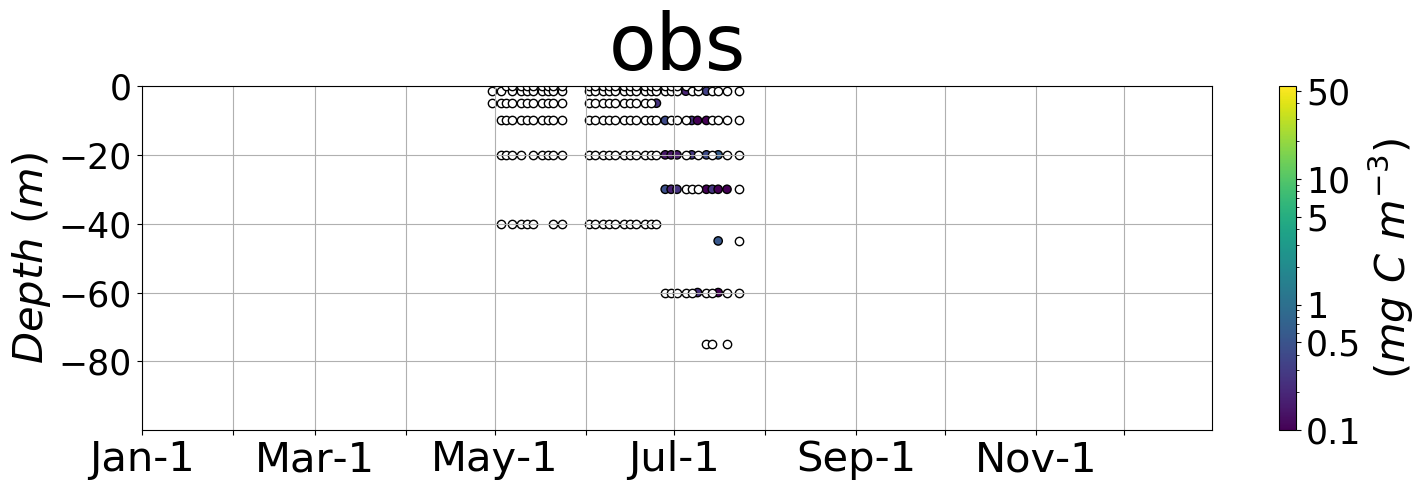

In [45]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(anabaenaobs_df['doy']-1,
                  anabaenaobs_df['depth'],
                  c=anabaenaobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(anabaenanoobs_df['doy']-1,
                  anabaenanoobs_df['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.anabaena.m3.png')

In [46]:
plt.close('all')

In [47]:
nT=365
array1d_iT_obsanabaenavint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsanabaenavint=np.NaN
    obsanabaena=[]
    doy=iT+1
    obsanabaena_oneday_df=anabaena_df[['depth','carbon_estimate_mg_c_m3']][(anabaena_df.doy==doy)]
    depths=obsanabaena_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obsanabaenatempo \
#             =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
#             assert obsanabaenatempo.size==1
#             obsanabaenatempo=obsanabaenatempo.iat[0]
#             obsanabaena.append(obsanabaenatempo)
#         obsanabaenavint=np.dot(obsanabaena,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obsanabaenatempo \
            =obsanabaena_oneday_df['carbon_estimate_mg_c_m3'][(obsanabaena_oneday_df.depth==depth)]
            assert obsanabaenatempo.size==1
            obsanabaenatempo=obsanabaenatempo.iat[0]
            obsanabaena.append(obsanabaenatempo)
        obsanabaenavint=np.dot(obsanabaena,weights_case9)
    array1d_iT_obsanabaenavint[iT]=obsanabaenavint

In [48]:
obsanabaenavinttotal=np.nansum(array1d_iT_obsanabaenavint)
obsanabaenavinttotal # mg C m^-2

79.30550688318908

In [49]:
obsanabaena_perc=obsanabaenavinttotal/obsallvinttotal*100
obsanabaena_perc # %

1.0175091095056699

The percentage of $Anabaena$ in the total phytoplankton biomass was small so it was not a problem if they were not well classified.

### Observations of $Cryptophyta$

In [50]:
cryptophytanotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                                   &  (groups_df.sample_type=='water') \
                                   & (
    (groups_df.taxonomy=='Cryptophytes') \
) \
                                  ]

In [51]:
# cryptophytanotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [52]:
cryptophyta_df=cryptophytanotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
cryptophytanoobs_df=cryptophyta_df[cryptophyta_df.carbon_estimate_mg_c_m3==0.0]
cryptophytaobs_df=cryptophyta_df[cryptophyta_df.carbon_estimate_mg_c_m3!=0.0]

In [53]:
# cryptophyta_df[['doy','depth','carbon_estimate_mg_c_m3']]

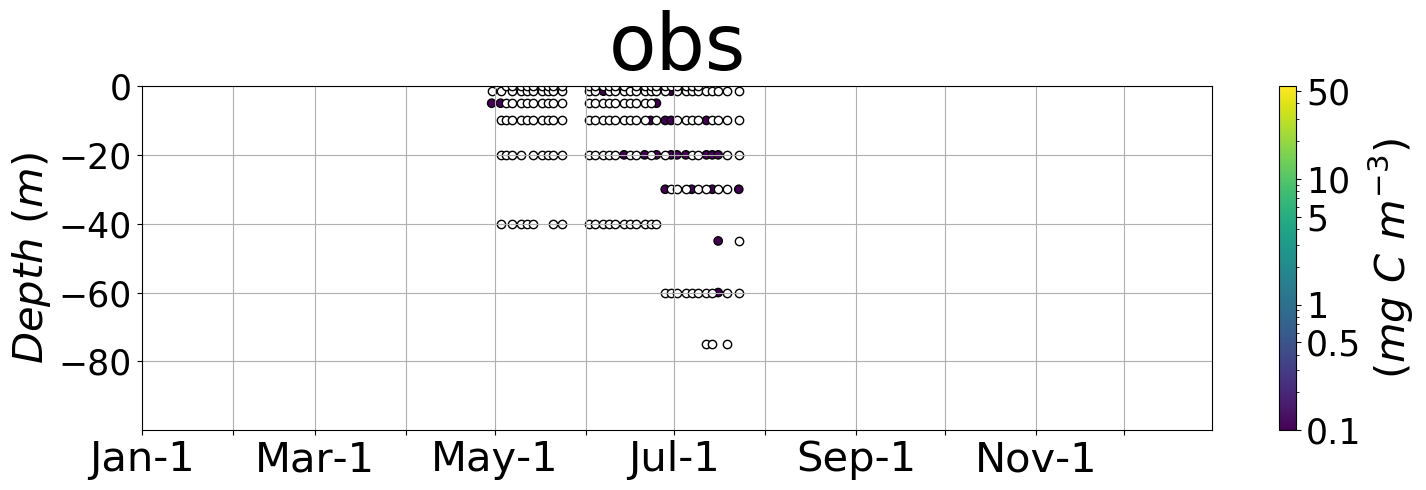

In [54]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(cryptophytaobs_df['doy']-1,
                  cryptophytaobs_df['depth'],
                  c=cryptophytaobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(cryptophytanoobs_df['doy']-1,
                  cryptophytanoobs_df['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.cryptophyta.m3.png')

In [55]:
plt.close('all')

In [56]:
nT=365
array1d_iT_obscryptophytavint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obscryptophytavint=np.NaN
    obscryptophyta=[]
    doy=iT+1
    obscryptophyta_oneday_df=cryptophyta_df[['depth','carbon_estimate_mg_c_m3']][(cryptophyta_df.doy==doy)]
    depths=obscryptophyta_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obscryptophytatempo \
#             =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
#             assert obscryptophytatempo.size==1
#             obscryptophytatempo=obscryptophytatempo.iat[0]
#             obscryptophyta.append(obscryptophytatempo)
#         obscryptophytavint=np.dot(obscryptophyta,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obscryptophytatempo \
            =obscryptophyta_oneday_df['carbon_estimate_mg_c_m3'][(obscryptophyta_oneday_df.depth==depth)]
            assert obscryptophytatempo.size==1
            obscryptophytatempo=obscryptophytatempo.iat[0]
            obscryptophyta.append(obscryptophytatempo)
        obscryptophytavint=np.dot(obscryptophyta,weights_case9)
    array1d_iT_obscryptophytavint[iT]=obscryptophytavint

In [57]:
obscryptophytavinttotal=np.nansum(array1d_iT_obscryptophytavint)
obscryptophytavinttotal # mg C m^-2

4.241151728434488

In [58]:
obscryptophyta_perc=obscryptophytavinttotal/obsallvinttotal*100
obscryptophyta_perc # %

0.05441501716689204

The percentage of $Cryptophyta$ in the total phytoplankton biomass was small so it was not a problem if they were not well classified.

### Observations of $Dictyocha$

In [59]:
dictyochanotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                                 &  (groups_df.sample_type=='water') \
                                 & (
    (groups_df.taxonomy=='Dictyocha') \
) \
                      ]

In [60]:
# dictyochanotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [61]:
dictyocha_df=dictyochanotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
dictyochanoobs_df=dictyocha_df[dictyocha_df.carbon_estimate_mg_c_m3==0.0]
dictyochaobs_df=dictyocha_df[dictyocha_df.carbon_estimate_mg_c_m3!=0.0]

In [62]:
# dictyocha_df[['doy','depth','carbon_estimate_mg_c_m3']]

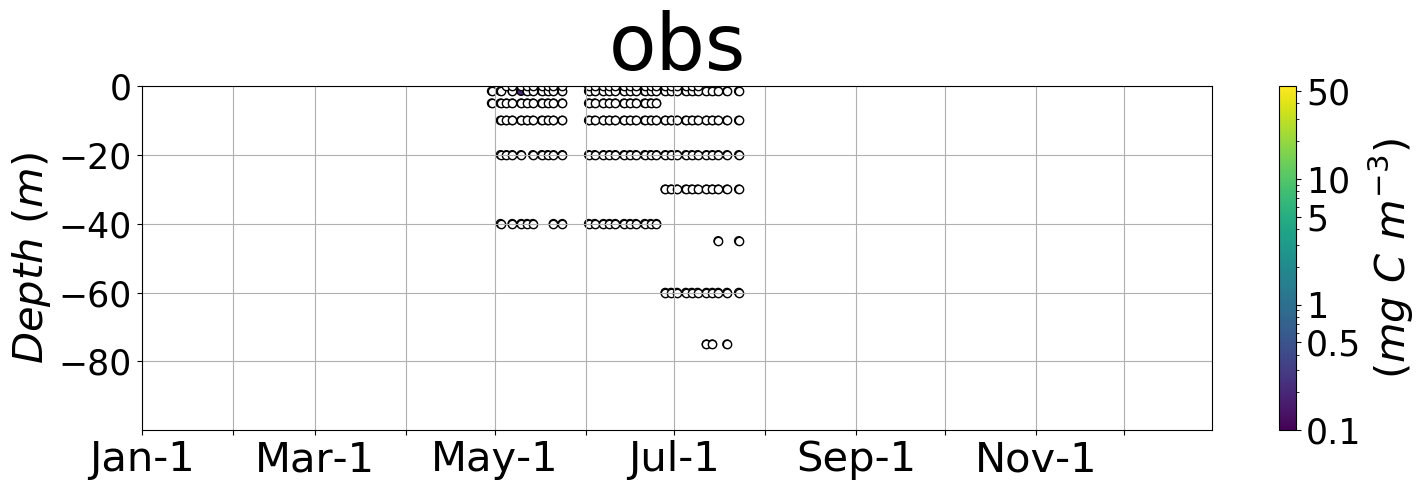

In [63]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(dictyocha_df['doy']-1,
                  dictyocha_df['depth'],
                  c=dictyocha_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(dictyochanoobs_df['doy']-1,
                  dictyochanoobs_df['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.dictyocha.m3.png')

In [64]:
plt.close('all')

In [65]:
nT=365
array1d_iT_obsdictyochavint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsdictyochavint=np.NaN
    obsdictyocha=[]
    doy=iT+1
    obsdictyocha_oneday_df=dictyocha_df[['depth','carbon_estimate_mg_c_m3']][(dictyocha_df.doy==doy)]
    depths=obsdictyocha_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obsdictyochatempo \
#             =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
#             assert obsdictyochatempo.size==1
#             obsdictyochatempo=obsdictyochatempo.iat[0]
#             obsdictyocha.append(obsdictyochatempo)
#         obsdictyochavint=np.dot(obsdictyocha,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obsdictyochatempo \
            =obsdictyocha_oneday_df['carbon_estimate_mg_c_m3'][(obsdictyocha_oneday_df.depth==depth)]
            assert obsdictyochatempo.size==1
            obsdictyochatempo=obsdictyochatempo.iat[0]
            obsdictyocha.append(obsdictyochatempo)
        obsdictyochavint=np.dot(obsdictyocha,weights_case9)
    array1d_iT_obsdictyochavint[iT]=obsdictyochavint

In [66]:
obsdictyochavinttotal=np.nansum(array1d_iT_obsdictyochavint)
obsdictyochavinttotal # mg C m^-2

0.506218895316124

In [67]:
obsdictyocha_perc=obsdictyochavinttotal/obsallvinttotal*100
obsdictyocha_perc # %

0.006494912618700361

The percentage of $Dictyocha$ in the total phytoplankton biomass was small so it was not a problem if they were not well classified.

### Observations of $Euglenozoa$

In [68]:
euglenozoanotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                                  &  (groups_df.sample_type=='water') \
                                  & (
    (groups_df.taxonomy=='Euglenozoa') \
) \
                      ]

In [69]:
# euglenozoanotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [70]:
euglenozoa_df=euglenozoanotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
euglenozoanoobs_df=euglenozoa_df[euglenozoa_df.carbon_estimate_mg_c_m3==0.0]
euglenozoaobs_df=euglenozoa_df[euglenozoa_df.carbon_estimate_mg_c_m3!=0.0]

In [71]:
# euglenozoa_df[['doy','depth','carbon_estimate_mg_c_m3']]

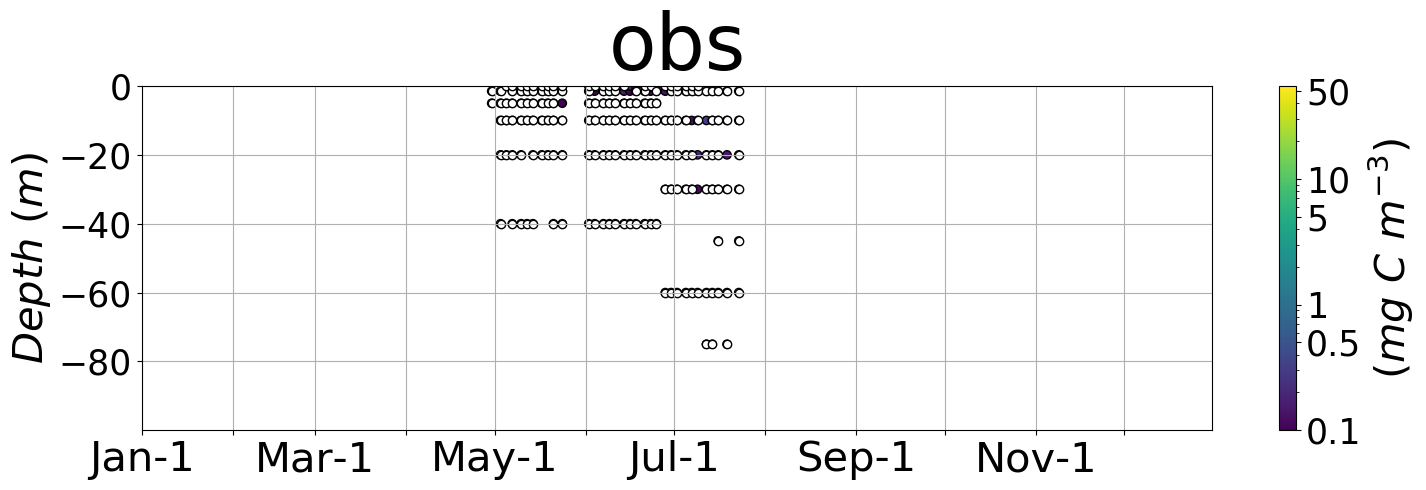

In [72]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(euglenozoa_df['doy']-1,
                  euglenozoa_df['depth'],
                  c=euglenozoa_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(euglenozoanoobs_df['doy']-1,
                  euglenozoanoobs_df['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.dictyocha.m3.png')

In [73]:
plt.close('all')

In [74]:
nT=365
array1d_iT_obseuglenozoavint=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obseuglenozoavint=np.NaN
    obseuglenozoa=[]
    doy=iT+1
    obseuglenozoa_oneday_df=euglenozoa_df[['depth','carbon_estimate_mg_c_m3']][(euglenozoa_df.doy==doy)]
    depths=obseuglenozoa_oneday_df['depth']
    # depths_case1 ([      -1.5, -5]) is too shallow for extrapolation
#     if np.array_equal(depths.sort_values(ascending=False),
#                       depths_case1):
#         for depth in depths.sort_values(ascending=False):
#             obseuglenozoatempo \
#             =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
#             assert obseuglenozoatempo.size==1
#             obseuglenozoatempo=obseuglenozoatempo.iat[0]
#             obseuglenozoa.append(obseuglenozoatempo)
#         obseuglenozoavint=np.dot(obseuglenozoa,weights_case1)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case2):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case2)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case3):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case3)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case4):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case4)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case5):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case5)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case6):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case6)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case7):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case7)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case8):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case8)
    if np.array_equal(depths.sort_values(ascending=False),
                      depths_case9):
        for depth in depths.sort_values(ascending=False):
            obseuglenozoatempo \
            =obseuglenozoa_oneday_df['carbon_estimate_mg_c_m3'][(obseuglenozoa_oneday_df.depth==depth)]
            assert obseuglenozoatempo.size==1
            obseuglenozoatempo=obseuglenozoatempo.iat[0]
            obseuglenozoa.append(obseuglenozoatempo)
        obseuglenozoavint=np.dot(obseuglenozoa,weights_case9)
    array1d_iT_obseuglenozoavint[iT]=obseuglenozoavint

In [75]:
obseuglenozoavinttotal=np.nansum(array1d_iT_obseuglenozoavint)
obseuglenozoavinttotal # mg C m^-2

12.07969553815201

In [76]:
obseuglenozoa_perc=obseuglenozoavinttotal/obsallvinttotal*100
obseuglenozoa_perc # %

0.15498545729275343

The percentage of $Euglenozoa$ in the total phytoplankton biomass was small so it was not a problem if they were not well classified.

### Observations of $Rhodomonas$

In [77]:
rhodomonasnotgrouped_df=groups_df[(groups_df.mission=='ice_camp_2016') \
                                  &  (groups_df.sample_type=='water') \
                                  & (
    (groups_df.taxonomy=='Rhodomonas') \
) \
                      ]

In [78]:
# rhodomonasnotgrouped_df[['doy','depth','carbon_estimate_mg_c_m3']]

In [79]:
rhodomonas_df=rhodomonasnotgrouped_df.groupby(['doy','depth']).agg({'carbon_estimate_mg_c_m3':'sum'}).reset_index()
rhodomonasnoobs_df=rhodomonas_df[rhodomonas_df.carbon_estimate_mg_c_m3==0.0]
rhodomonasobs_df=rhodomonas_df[rhodomonas_df.carbon_estimate_mg_c_m3!=0.0]

In [80]:
# rhodomonas_df[['doy','depth','carbon_estimate_mg_c_m3']]

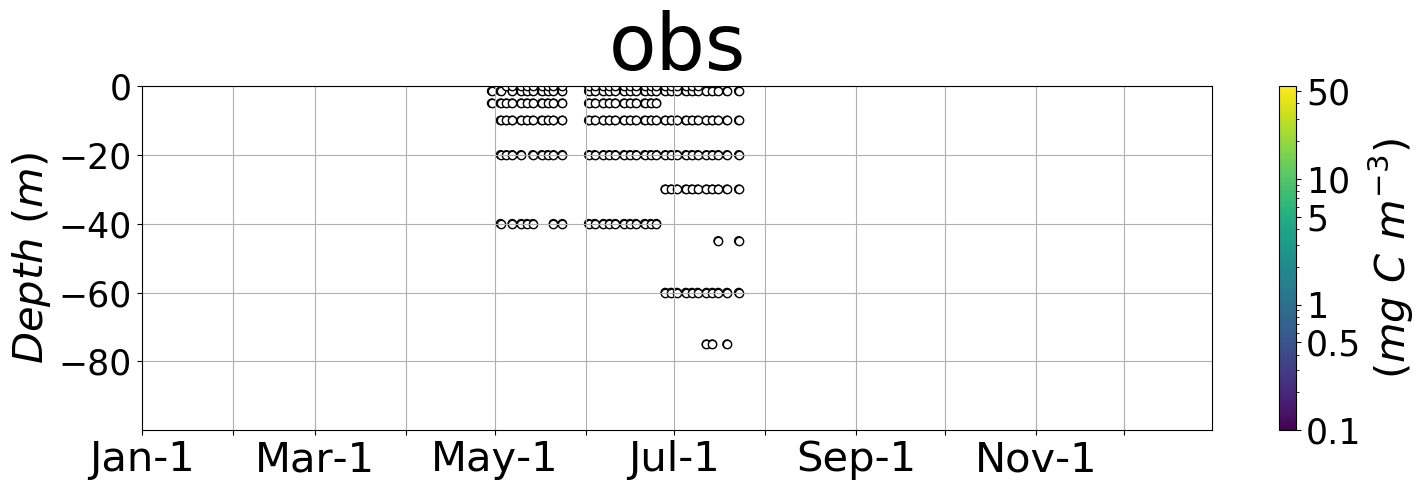

In [81]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(rhodomonas_df['doy']-1,
                  rhodomonas_df['depth'],
                  c=rhodomonas_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(rhodomonasnoobs_df['doy']-1,
                  rhodomonasnoobs_df['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('obs')
    ax.set_xticklabels([])
    ax.set_ylabel('$Depth\ (m)$')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(-100,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,-20,-40,-60,-80])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.obs.rhodomonas.m3.png')

In [82]:
plt.close('all')

In [83]:
np.max(rhodomonas_df[['carbon_estimate_mg_c_m3']])

carbon_estimate_mg_c_m3    0.0
dtype: float32

There was no $Rhodomonas$ so it was not a problem if they were not well classified.

## Observations of biogeochemical functional groups: picophytoplankton

The Imager FlowCytobot (IFCB) was not able to detect picophytoplankton.
The picophytoplankton is defined as phytoplankton with an Equivalent Spherical Diameter $<2\ \mu m$.

# Simulation of nutrients (0-100m)

## Simulation of nutrients (0-100m): nitrate ($\mathrm{ NO_3 }$)

In $\mathrm{ mmol\ N\ m^{-2} }$.

In [84]:
carfile='car.0000000000.t001.nc'
# nitrate; mmol N m^-3
array2d_idepth_iT_nitrate\
=netcdf_tools.read_netcdf(carfile, 'TRAC04').squeeze().transpose()
# nitrate; mmol N m^-2
array1d_iT_nitrate0to100=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_nitrate,
    array1d_idepth_delR=drF,
    depth_end=-100)
# nitrate on May 15; mmol N m^-2
nitrate0to100_onMay15=array1d_iT_nitrate0to100[last_year][134]
# nitrate0to100_onMay15

## Simulation of nutrients (0-100m): silicic acid ($\mathrm{ Si(OH)_4 }$)

In $\mathrm{ mmol\ Si\ m^{-2} }$.

In [85]:
carfile='car.0000000000.t001.nc'
# silicic acid; mmol N m^-3
array2d_idepth_iT_silicic\
=netcdf_tools.read_netcdf(carfile, 'TRAC06').squeeze().transpose()
# silicic acid; mmol N m^-2
array1d_iT_silicic0to100=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_silicic,
    array1d_idepth_delR=drF,
    depth_end=-100)
# silicic acid on May 15; mmol N m^-2
silicic0to100_onMay15=array1d_iT_silicic0to100[last_year][134]
# silicic0to100_onMay15

## Simulation of nutrients (0-100m): write

In [86]:
df=pd.DataFrame({
    'nitrate0_100_onMay15_mmolNm2'     :[nitrate0to100_onMay15],
    'silicicacid0_100_onMay15_mmolSim2':[silicic0to100_onMay15]
})
df

nitrate0_100_onMay15_mmolNm2  silicicacid0_100_onMay15_mmolSim2
0                    563.319967                         812.848079

In [87]:
outfile='nutrients.csv'
df.to_csv(outfile,index=False)

In [88]:
outfile_long='nutrients.'+os.path.basename(os.getcwd())+'.csv'
shutil.copy(outfile,outfile_long)

'nutrients.run_20230707_0000_EXP0_translucent_snow.csv'

# Simulation of chlorophyll $a$ (0-100m)

in $mg\ Chl\ a\ m^{-2}$

In [89]:
chlfile='chl.0000000000.t001.nc';

array2d_idepth_iT_prochlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC70').squeeze().transpose()
array2d_idepth_iT_prochlfull[-1,:]=np.nan

array2d_idepth_iT_synchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC71').squeeze().transpose()
array2d_idepth_iT_synchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleuk1umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC72').squeeze().transpose()
array2d_idepth_iT_smalleuk1umchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleuk2umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC73').squeeze().transpose()
array2d_idepth_iT_smalleuk2umchlfull[-1,:]=np.nan

array2d_idepth_iT_smalleukchlfull\
=array2d_idepth_iT_smalleuk1umchlfull+array2d_idepth_iT_smalleuk2umchlfull

array2d_idepth_iT_cocco3umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC74').squeeze().transpose()
array2d_idepth_iT_cocco3umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco4umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC75').squeeze().transpose()
array2d_idepth_iT_cocco4umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC76').squeeze().transpose()
array2d_idepth_iT_cocco7umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC77').squeeze().transpose()
array2d_idepth_iT_cocco10umchlfull[-1,:]=np.nan
array2d_idepth_iT_cocco15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC78').squeeze().transpose()
array2d_idepth_iT_cocco15umchlfull[-1,:]=np.nan

array2d_idepth_iT_coccochlfull\
=array2d_idepth_iT_cocco3umchlfull+array2d_idepth_iT_cocco4umchlfull\
+array2d_idepth_iT_cocco7umchlfull+array2d_idepth_iT_cocco10umchlfull\
+array2d_idepth_iT_cocco15umchlfull

array2d_idepth_iT_diazo3umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC79').squeeze().transpose()
array2d_idepth_iT_diazo3umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo4umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC80').squeeze().transpose()
array2d_idepth_iT_diazo4umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC81').squeeze().transpose()
array2d_idepth_iT_diazo7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diazo10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC82').squeeze().transpose()
array2d_idepth_iT_diazo10umchlfull[-1,:]=np.nan

array2d_idepth_iT_diazochlfull\
=array2d_idepth_iT_diazo3umchlfull+array2d_idepth_iT_diazo4umchlfull\
+array2d_idepth_iT_diazo7umchlfull+array2d_idepth_iT_diazo10umchlfull

array2d_idepth_iT_trichlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC83').squeeze().transpose()
array2d_idepth_iT_trichlfull[-1,:]=np.nan

array2d_idepth_iT_diatom7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC84').squeeze().transpose()
array2d_idepth_iT_diatom7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC85').squeeze().transpose()
array2d_idepth_iT_diatom10umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC86').squeeze().transpose()
array2d_idepth_iT_diatom15umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom22umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC87').squeeze().transpose()
array2d_idepth_iT_diatom22umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom32umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC88').squeeze().transpose()
array2d_idepth_iT_diatom32umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom47umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC89').squeeze().transpose()
array2d_idepth_iT_diatom47umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom70umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC90').squeeze().transpose()
array2d_idepth_iT_diatom70umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom104umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC91').squeeze().transpose()
array2d_idepth_iT_diatom104umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom154umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC92').squeeze().transpose()
array2d_idepth_iT_diatom154umchlfull[-1,:]=np.nan

array2d_idepth_iT_diatomchlfull\
=array2d_idepth_iT_diatom7umchlfull+array2d_idepth_iT_diatom10umchlfull\
+array2d_idepth_iT_diatom15umchlfull+array2d_idepth_iT_diatom22umchlfull\
+array2d_idepth_iT_diatom32umchlfull+array2d_idepth_iT_diatom47umchlfull\
+array2d_idepth_iT_diatom70umchlfull+array2d_idepth_iT_diatom104umchlfull\
+array2d_idepth_iT_diatom154umchlfull

array2d_idepth_iT_largeeuk7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC93').squeeze().transpose()
array2d_idepth_iT_largeeuk7umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk10umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC94').squeeze().transpose()
array2d_idepth_iT_largeeuk10umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk15umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC95').squeeze().transpose()
array2d_idepth_iT_largeeuk15umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk22umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC96').squeeze().transpose()
array2d_idepth_iT_largeeuk22umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk32umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC97').squeeze().transpose()
array2d_idepth_iT_largeeuk32umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk47umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC98').squeeze().transpose()
array2d_idepth_iT_largeeuk47umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk70umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC99').squeeze().transpose()
array2d_idepth_iT_largeeuk70umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk104umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0a').squeeze().transpose()
array2d_idepth_iT_largeeuk104umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk154umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0b').squeeze().transpose()
array2d_idepth_iT_largeeuk154umchlfull[-1,:]=np.nan
array2d_idepth_iT_largeeuk228umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC0c').squeeze().transpose()
array2d_idepth_iT_largeeuk228umchlfull[-1,:]=np.nan

array2d_idepth_iT_largeeukchlfull\
=array2d_idepth_iT_largeeuk7umchlfull+array2d_idepth_iT_largeeuk10umchlfull\
+array2d_idepth_iT_largeeuk15umchlfull+array2d_idepth_iT_largeeuk22umchlfull\
+array2d_idepth_iT_largeeuk32umchlfull+array2d_idepth_iT_largeeuk47umchlfull\
+array2d_idepth_iT_largeeuk70umchlfull+array2d_idepth_iT_largeeuk104umchlfull\
+array2d_idepth_iT_largeeuk154umchlfull+array2d_idepth_iT_largeeuk228umchlfull

array2d_idepth_iT_modchlfull\
=array2d_idepth_iT_prochlfull+array2d_idepth_iT_synchlfull\
+array2d_idepth_iT_smalleukchlfull+array2d_idepth_iT_coccochlfull\
+array2d_idepth_iT_diazochlfull+array2d_idepth_iT_trichlfull\
+array2d_idepth_iT_diatomchlfull+array2d_idepth_iT_largeeukchlfull

In [90]:
# mg Chl-a m^-2
array1d_iT_modvintchlfull\
=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modchlfull,
    array1d_idepth_delR=drF,
    depth_end=-100)

array1d_iT_modvintchl=array1d_iT_modvintchlfull[last_year]

## Simulation of chlorophyll $a$ (0-100m): bloom peak

The first local maximum was July 16 with 40.3 mg Chl m^{-2}. The global maximum was August 2 with 42.6 mg Chl m^{-3}.

Fig. 9 of Benoit-Gagne et al. (submitted; EXP-3 of my Chapter 1) shows that the first local maximum moved little from one sensitivity experiment on winter nitrate with the other.
However, the global maximum jumped between the standard run and the sensitivity experiments with decreased winter nitrate.
Because of this, we considered the bloom peak as the first local maximum.

In [91]:
global_maximum_date=np.nanargmax(array1d_iT_modvintchl)

In [92]:
first_local_maximum_date=scipy.signal.argrelextrema(array1d_iT_modvintchl,
                                                    np.greater)[0][0]

In [93]:
# date_peak=global_maximum_date
date_peak=first_local_maximum_date

Day of year

In [94]:
date_peak+1

198

In [95]:
year=2016
first_local_maximum_dates=datetime.datetime(year,1,1)\
+ datetime.timedelta(first_local_maximum_date.item())
first_local_maximum_dates.strftime("%B %d")

'July 16'

In [96]:
first_local_maximum_value=array1d_iT_modvintchl[date_peak]

(in $mg\ Chl\ m^{-2}$)

In [97]:
first_local_maximum_value

50.474566663886435

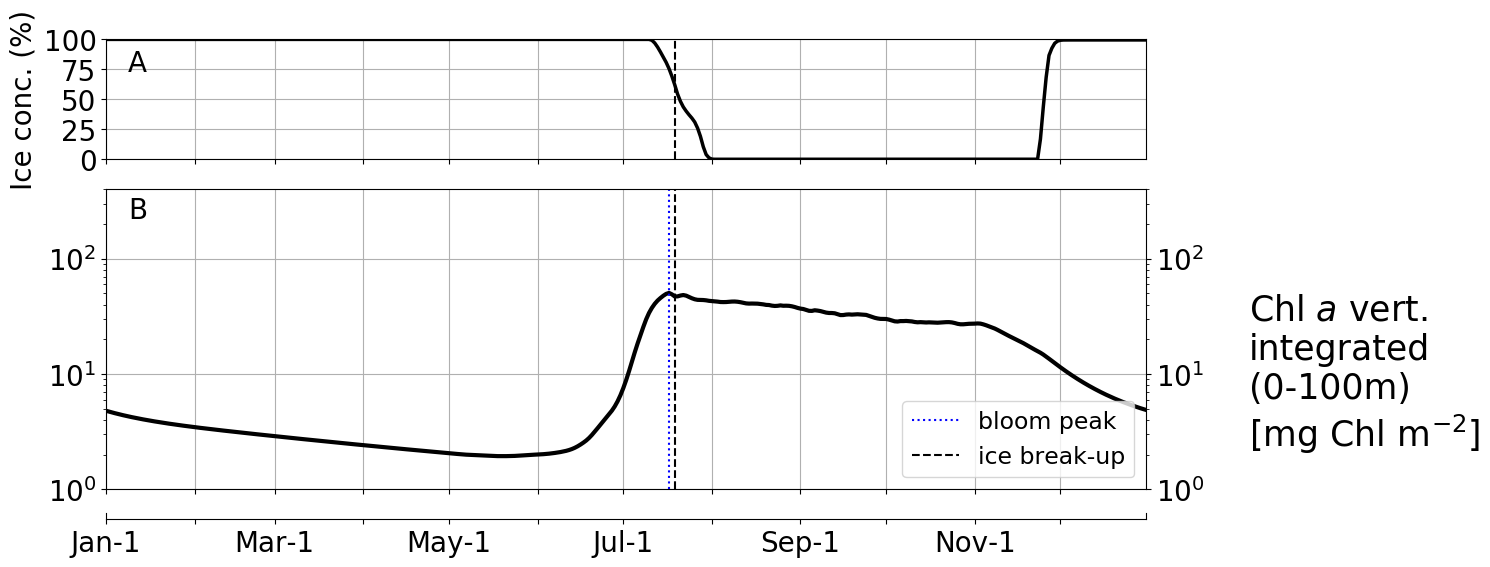

In [98]:
with plt.style.context('validation.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')

    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc. (%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.8,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding the vertical line at 15% of observed ice
    ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- CHLOROPHYLL A
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_modvintchl,color='black',lw=3)
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(1E0,4E2)
    ax.grid()
    ax.text(400,10,'Chl $a$ vert.\nintegrated\n(0-100m)\n[$\mathrm{mg\ Chl\ m^{-2}}$]',
            horizontalalignment = 'left',
            verticalalignment = 'center',
            fontsize=25)
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':',
               label='bloom peak')
    # adding the vertical line at 15% of observed ice
    ax.axvline(iT15_start_obs,color='k',linestyle='--',
               label='ice break-up')
    ax.legend(loc='lower right')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.70  ,0.65,.20])
    axs[1].set_position( [0.12,0.15  ,0.65,.50])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('chl.0000000000.t001.lastyear.logchlvint100m.png')

In [99]:
plt.close('all')

# Simulation of biogeochemical functional groups

## Simulation of biogeochemical functional groups: diatoms

In [100]:
carfile='car.0000000000.t001.nc'
RF_above105=RF[RF>-105]
array2d_idepth_iT_simdiatom=np.zeros([RF_above105.size-1,365])
for itracer in range(35,44):
    varname='TRAC'+str(itracer).zfill(2)
    array2d_idepth_iT_simdiatomfull=netcdf_tools.read_netcdf(carfile, varname)\
.squeeze().transpose()
    array2d_idepth_iT_simdiatomtempo \
    =array2d_idepth_iT_simdiatomfull[0:(RF_above105.size)-1,
                                     last_year]
    array2d_idepth_iT_simdiatom=array2d_idepth_iT_simdiatom+array2d_idepth_iT_simdiatomtempo
molarmassC=12.0107 # g C (mol C)^-1
# mmol C m^-3 -> mg C m^-3
array2d_idepth_iT_simdiatom=array2d_idepth_iT_simdiatom*molarmassC

Let $\mathrm{ C_{dia} }$ be the diatoms' biomass
($\mathrm{ mg\ C\ m^{-3} }$).

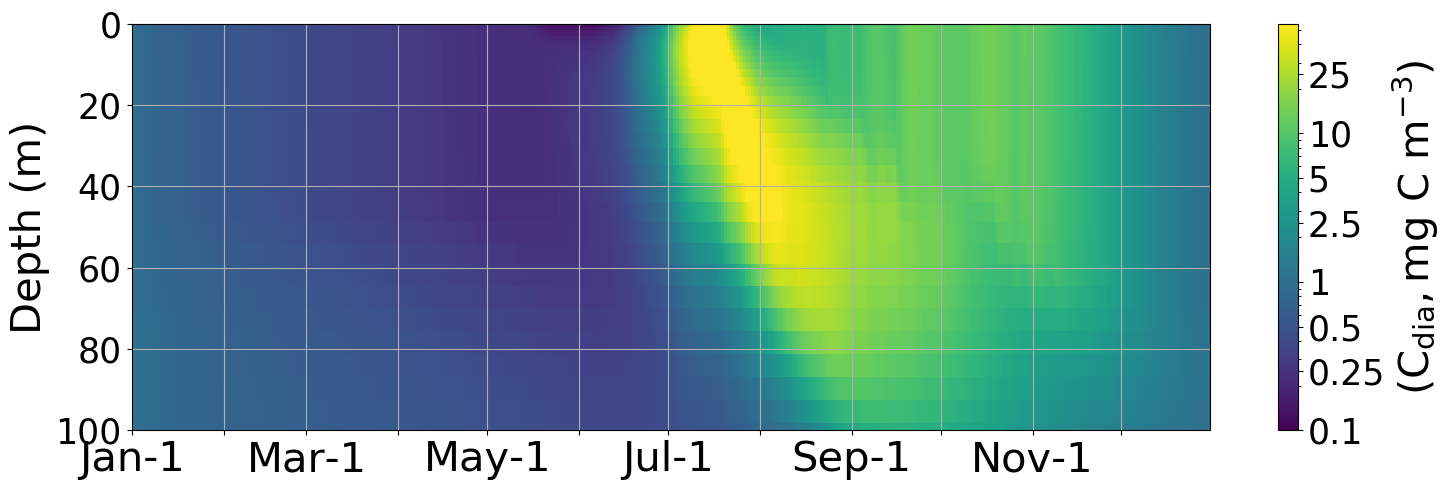

In [101]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simdiatom,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{dia}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.diatoms.m3.png')

In [102]:
plt.close('all')

### Simulation of biogeochemical functional groups: diatoms: on the grid for the observations

The values of diatoms biomass at -0.51 m on the model grid are extrapolated to 0 m. It is the only extrapolation.

In [103]:
RC_above105=RC[RC>-105]
array1d_iobs_simdiatom=list()
for iobs,row in diatomsobs_df.iterrows():
    doy=row['doy']
    doy=doy.astype(np.int64)
    depthobs=row['depth']
    assert depthobs<=0, \
    "depthobs is positive: %r" %(depthobs)
    assert depthobs>RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC_above105,
        array2d_idepth_iT_simdiatom[:,doy-1].flatten(),
        bounds_error=False,
        fill_value='extrapolate'
    )
    simdiatom=y_interp(depthobs).item()
    array1d_iobs_simdiatom.append(simdiatom)
simdiatom_df=pd.DataFrame({
    'doy':diatomsobs_df['doy'],
    'depth':diatomsobs_df['depth'],
    'carbon_estimate_mg_c_m3':array1d_iobs_simdiatom,
})

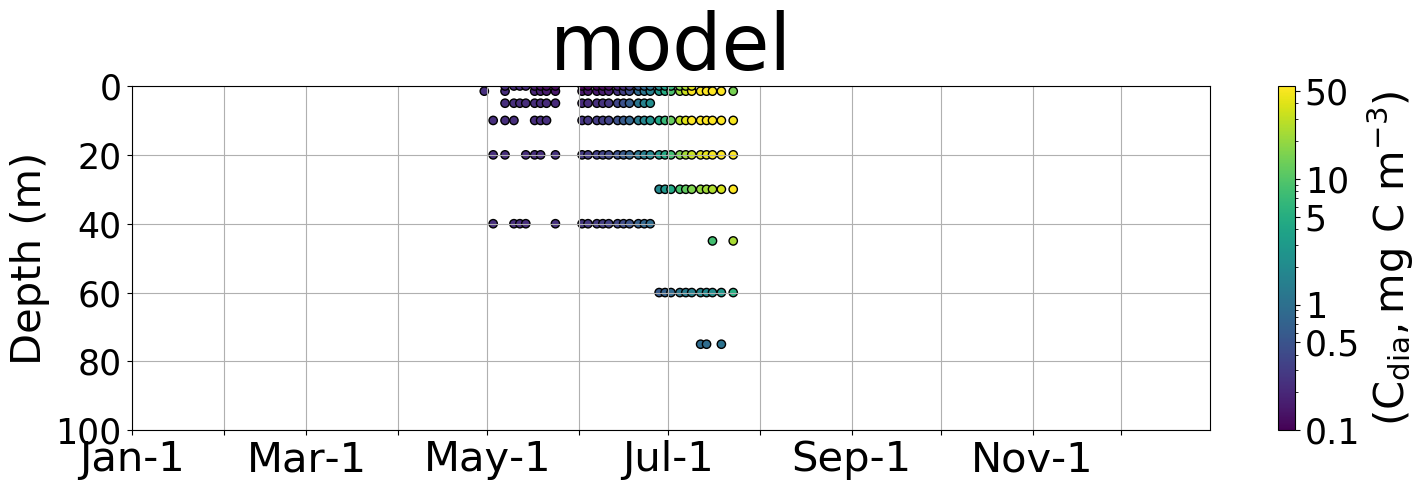

In [104]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(simdiatom_df['doy']-1,
                  -simdiatom_df['depth'],
                  c=simdiatom_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    ax.set_title('model')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{dia}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.diatoms.m3.obsgrid.png')

In [105]:
plt.close('all')

### Simulation of biogeochemical functional groups: diatoms: vertically integrated biomass ($0-100\ m$; $mg\ C\ m^{-2}$)

In [106]:
# mg C m^-3 -> mg C m^-2
array1d_iT_simdiatomvint\
=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_simdiatom,
    array1d_idepth_delR=drF,
    depth_end=-100)

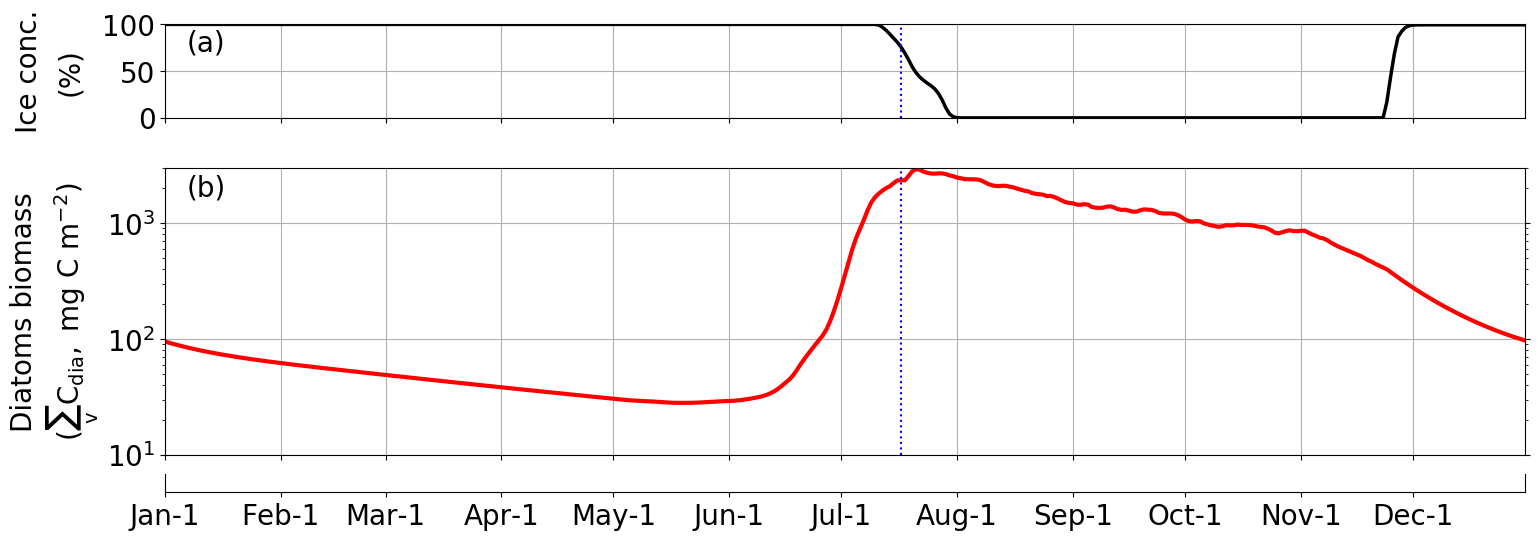

In [107]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.')
    ax.yaxis.set_label_coords(-0.09,0.5)
    plt.text(-0.07,0.5,'(%)',
             rotation='vertical',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.8,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdiatomvint,
               '-',lw=3,color='red')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Diatoms biomass'
                  '\n($\mathrm{ \sum_{v} C_{dia},\ mg\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(1E1,3E3)
    ax.grid()
    plt.text(0.03,0.93,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.75  ,0.85,0.15])
    axs[1].set_position( [0.12,0.21  ,0.85,0.46])
    axs[2].set_position( [0.12,0.15  ,0.85,0.03])

with plt.style.context('ice.mplstyle'):   
    # Plot
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6.24))
    make_plots(axs)

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.diatoms.vint100m.png')

### Simulation of biogeochemical functional groups: diatoms: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass after the bloom peak ($g\ C\ m^{-2}$)

In [108]:
simdiatomvintafterpeak=np.sum(array1d_iT_simdiatomvint[date_peak+1:])/1000

### Simulation of biogeochemical functional groups: diatoms: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass ($g\ C\ m^{-2}$)

In [109]:
simdiatomvint=np.sum(array1d_iT_simdiatomvint[:])/1000

## Simulation of biogeochemical functional groups: dinoflagellates

In [110]:
carfile='car.0000000000.t001.nc'
RF_above105=RF[RF>-105]
array2d_idepth_iT_simdino=np.zeros([RF_above105.size-1,365])
for itracer in range(44,54):
    varname='TRAC'+str(itracer).zfill(2)
    array2d_idepth_iT_simdinofull=netcdf_tools.read_netcdf(carfile, varname)\
.squeeze().transpose()
    array2d_idepth_iT_simdinotempo \
    =array2d_idepth_iT_simdinofull[0:(RF_above105.size)-1,
                                   last_year]
    array2d_idepth_iT_simdino=array2d_idepth_iT_simdino+array2d_idepth_iT_simdinotempo
molarmassC=12.0107 # g C (mol C)^-1
# mmol C m^-3 -> mg C m^-3
array2d_idepth_iT_simdino=array2d_idepth_iT_simdino*molarmassC

Let $\mathrm{ C_{dino} }$ be the dinoflagellates' biomass
($\mathrm{ mg\ C\ m^{-3} }$).

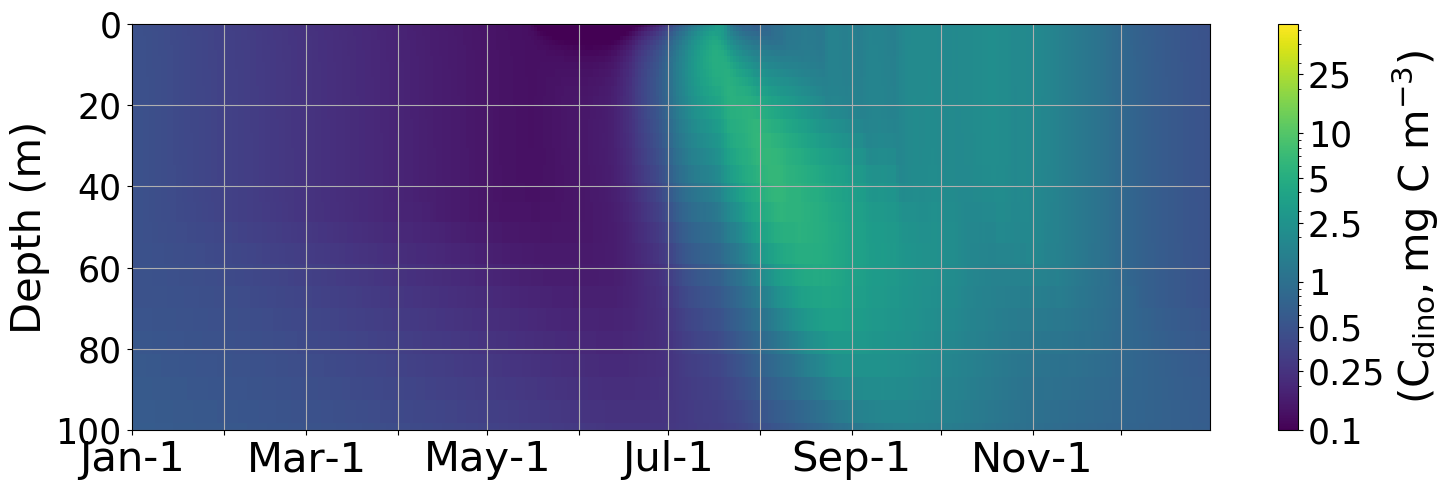

In [111]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simdino,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{dino}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.dino.m3.png')

In [112]:
plt.close('all')

### Simulation of biogeochemical functional groups: dinoflagellates: on the grid for the observations

The values of dinoflagellates biomass at -0.51 m on the model grid are extrapolated to 0 m. It is the only extrapolation.

In [113]:
RC_above105=RC[RC>-105]
array1d_iobs_simdino=list()
for iobs,row in dinoobs_df.iterrows():
    doy=row['doy']
    doy=doy.astype(np.int64)
    depthobs=row['depth']
    assert depthobs<=0, \
    "depthobs is positive: %r" %(depthobs)
    assert depthobs>RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC_above105,
        array2d_idepth_iT_simdino[:,doy-1].flatten(),
        bounds_error=False,
        fill_value='extrapolate'
    )
    simdino=y_interp(depthobs).item()
    array1d_iobs_simdino.append(simdino)
simdino_df=pd.DataFrame({
    'doy':dinoobs_df['doy'],
    'depth':dinoobs_df['depth'],
    'carbon_estimate_mg_c_m3':array1d_iobs_simdino,
})

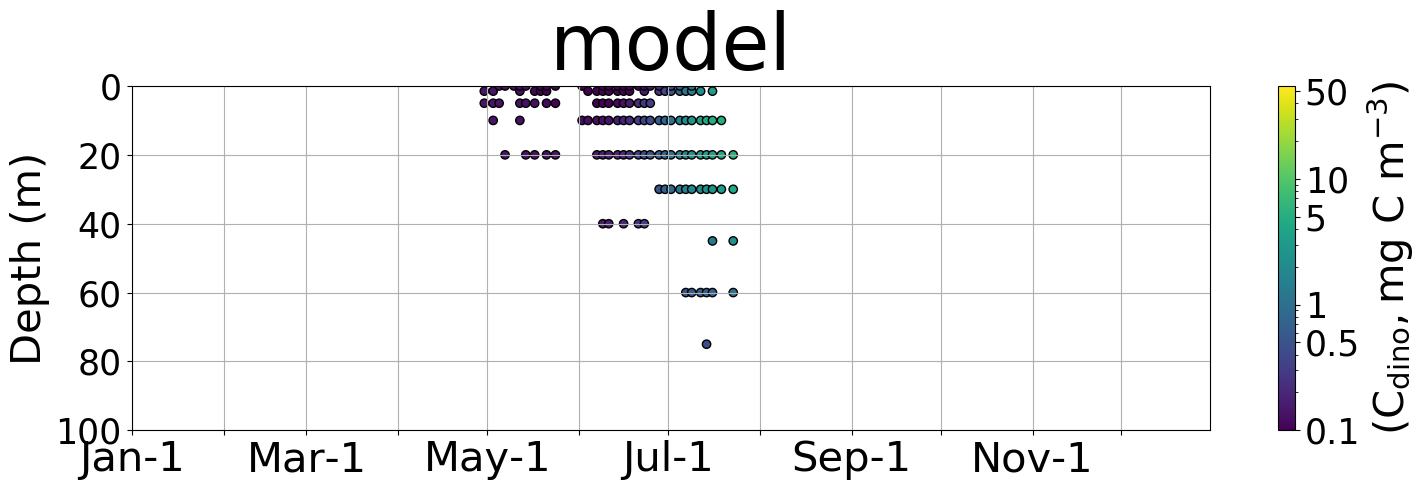

In [114]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(simdino_df['doy']-1,
                  -simdino_df['depth'],
                  c=simdino_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    ax.set_title('model')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{dino}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.dino.m3.obsgrid.png')

In [115]:
plt.close('all')

### Simulation of biogeochemical functional groups: dinoflagellates: vertically integrated biomass ($0-100\ m$; $mg\ C\ m^{-2}$)

In [116]:
# mg C m^-3 -> mg C m^-2
array1d_iT_simdinovint\
=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_simdino,
    array1d_idepth_delR=drF,
    depth_end=-100)

### Simulation of biogeochemical functional groups: dinoflagellates: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass after the bloom peak ($g\ C\ m^{-2}$)

In [117]:
simdinovintafterpeak=np.sum(array1d_iT_simdinovint[date_peak+1:])/1000

### Simulation of biogeochemical functional groups: dinoflagellates: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass ($g\ C\ m^{-2}$)

In [118]:
simdinovint=np.sum(array1d_iT_simdinovint[:])/1000

## Simulation of biogeochemical functional groups: other nanoeukaryotes

In [119]:
carfile='car.0000000000.t001.nc'
RF_above105=RF[RF>-105]
array2d_idepth_iT_simother=np.zeros([RF_above105.size-1,365])
for itracer in range(25,30):
    varname='TRAC'+str(itracer).zfill(2)
    array2d_idepth_iT_simotherfull=netcdf_tools.read_netcdf(carfile, varname)\
.squeeze().transpose()
    array2d_idepth_iT_simothertempo \
    =array2d_idepth_iT_simotherfull[0:(RF_above105.size)-1,
                                    last_year]
    array2d_idepth_iT_simother=array2d_idepth_iT_simother+array2d_idepth_iT_simothertempo
molarmassC=12.0107 # g C (mol C)^-1
# mmol C m^-3 -> mg C m^-3
array2d_idepth_iT_simother=array2d_idepth_iT_simother*molarmassC

Let $\mathrm{ C_{other} }$ be the other nanophytoplankton's biomass
($\mathrm{ mg\ C\ m^{-3} }$).

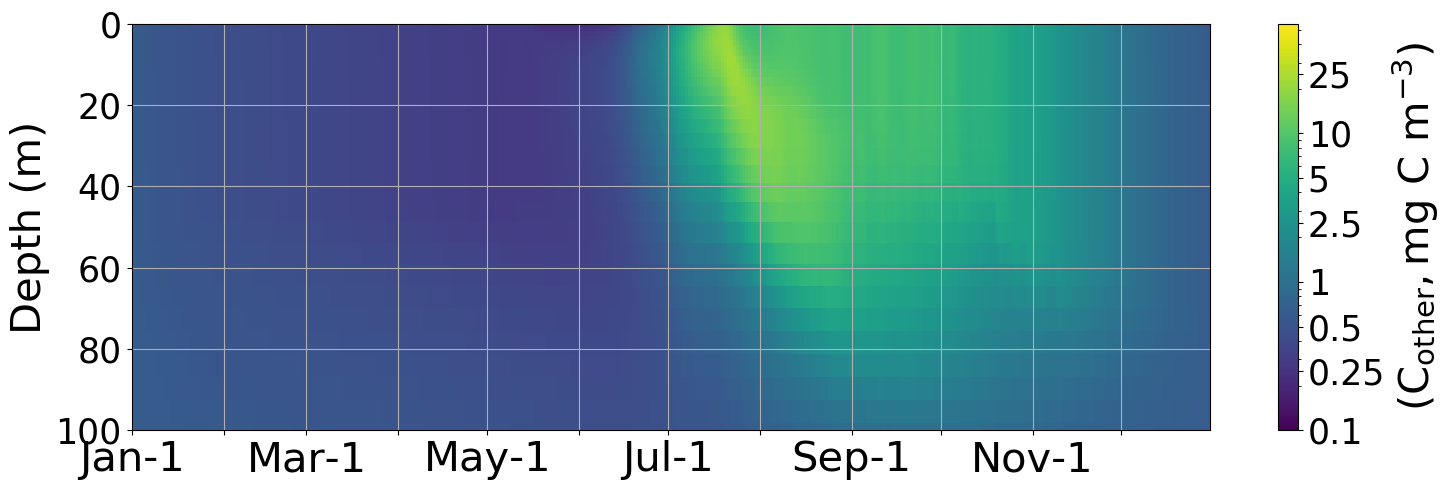

In [120]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simother,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{other}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.other.m3.png')

In [121]:
plt.close('all')

### Simulation of biogeochemical functional groups: nanoeukaryotes: on the grid for the observations

The values of nanoeukaryotes biomass at -0.51 m on the model grid are extrapolated to 0 m. It is the only extrapolation.

In [122]:
RC_above105=RC[RC>-105]
array1d_iobs_simother=list()
for iobs,row in otherobs_df.iterrows():
    doy=row['doy']
    doy=doy.astype(np.int64)
    depthobs=row['depth']
    assert depthobs<=0, \
    "depthobs is positive: %r" %(depthobs)
    assert depthobs>RC[-1], \
    "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
    y_interp=scipy.interpolate.interp1d(
        RC_above105,
        array2d_idepth_iT_simother[:,doy-1].flatten(),
        bounds_error=False,
        fill_value='extrapolate'
    )
    simother=y_interp(depthobs).item()
    array1d_iobs_simother.append(simother)
simother_df=pd.DataFrame({
    'doy':otherobs_df['doy'],
    'depth':otherobs_df['depth'],
    'carbon_estimate_mg_c_m3':array1d_iobs_simother,
})

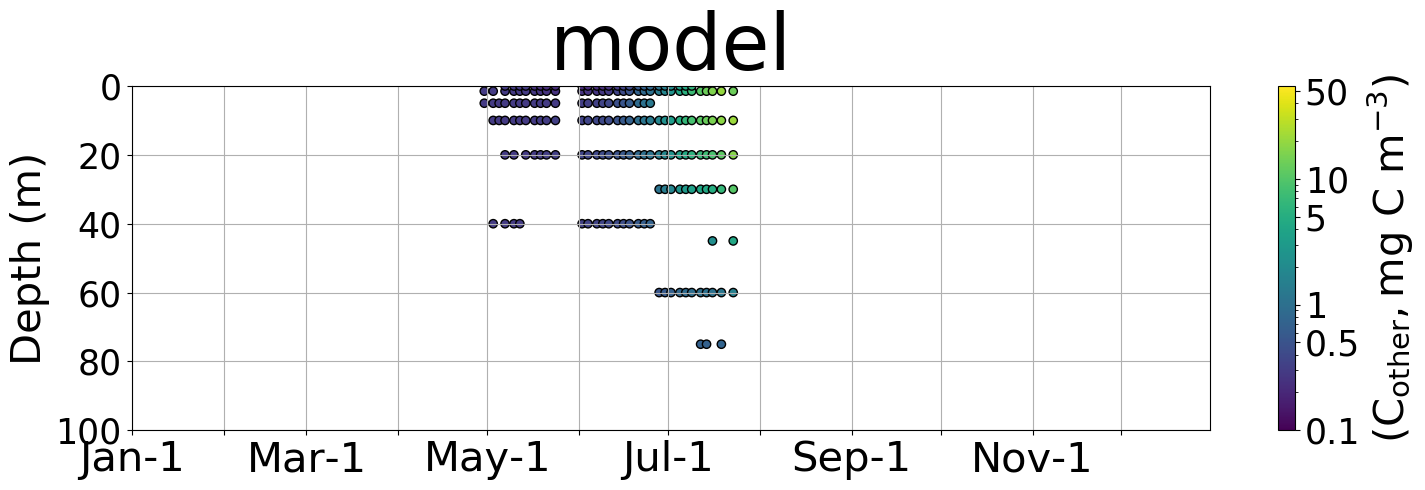

In [123]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(simother_df['doy']-1,
                  -simother_df['depth'],
                  c=simother_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    ax.set_title('model')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.5,1,5,10,50]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{other}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.other.m3.obsgrid.png')

In [124]:
plt.close('all')

### Simulation of biogeochemical functional groups: other nanoeukaryotes: vertically integrated biomass ($0-100\ m$; $mg\ C\ m^{-2}$)

In [125]:
# mg C m^-3 -> mg C m^-2
array1d_iT_simothervint\
=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_simother,
    array1d_idepth_delR=drF,
    depth_end=-100)

### Simulation of biogeochemical functional groups: other nanoeukaryotes: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass after the bloom peak ($g\ C\ m^{-2}$)

In [126]:
simothervintafterpeak=np.sum(array1d_iT_simothervint[date_peak+1:])/1000

### Simulation of biogeochemical functional groups: other nanoeukaryotes: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass ($g\ C\ m^{-2}$)

In [127]:
simothervint=np.sum(array1d_iT_simothervint[:])/1000

## Simulation of biogeochemical functional groups: picophytoplankton

In [128]:
carfile='car.0000000000.t001.nc'
RF_above105=RF[RF>-105]
array2d_idepth_iT_simpico=np.zeros([RF_above105.size-1,365])
for itracer in range(21,25):
    varname='TRAC'+str(itracer).zfill(2)
    array2d_idepth_iT_simpicofull=netcdf_tools.read_netcdf(carfile, varname)\
.squeeze().transpose()
    array2d_idepth_iT_simpicotempo \
    =array2d_idepth_iT_simpicofull[0:(RF_above105.size)-1,
                                   last_year]
    array2d_idepth_iT_simpico=array2d_idepth_iT_simpico+array2d_idepth_iT_simpicotempo
molarmassC=12.0107 # g C (mol C)^-1
# mmol C m^-3 -> mg C m^-3
array2d_idepth_iT_simpico=array2d_idepth_iT_simpico*molarmassC

Let $\mathrm{ C_{pico} }$ be the picophytoplankton's biomass
($\mathrm{ mg\ C\ m^{-3} }$).

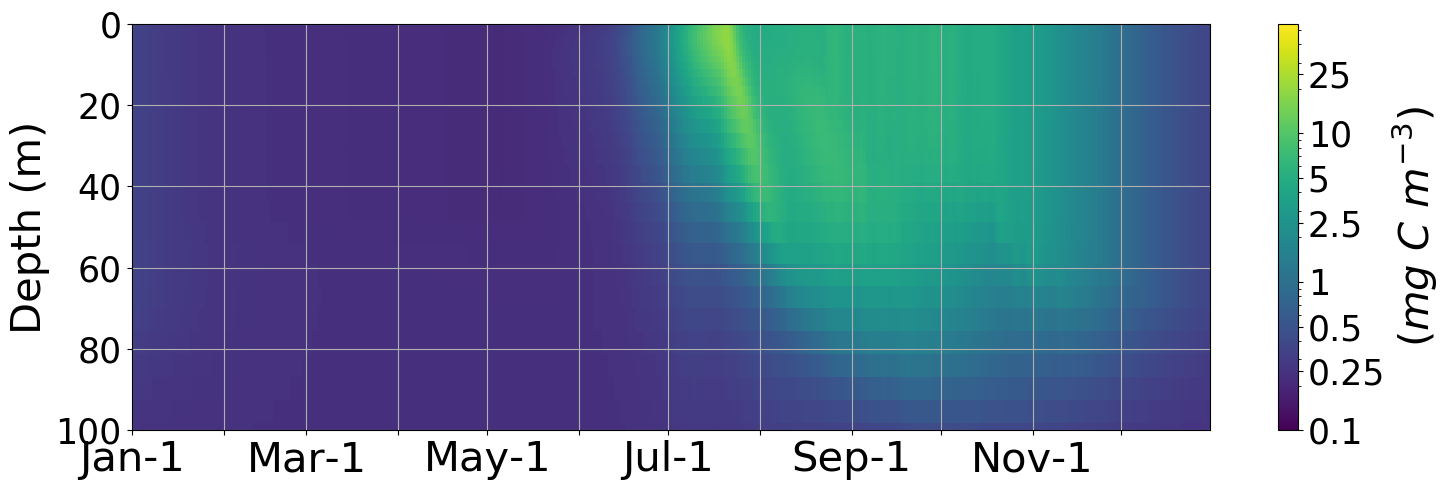

In [129]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simpico,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$(mg\ C\ m^{-3})$')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.year10.pico.m3.png')

In [130]:
plt.close('all')

### Simulation of biogeochemical functional groups: picophytoplankton: vertically integrated biomass ($0-100\ m$; $mg\ C\ m^{-2}$)

In [131]:
# mg C m^-3 -> mg C m^-2
array1d_iT_simpicovint\
=vstats.vint(
    array2d_idepth_iT_tracer=array2d_idepth_iT_simpico,
    array1d_idepth_delR=drF,
    depth_end=-100)

### Simulation of biogeochemical functional groups: picophytoplankton: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass after the bloom peak ($g\ C\ m^{-2}$)

In [132]:
simpicovintafterpeak=np.sum(array1d_iT_simpicovint[date_peak+1:])/1000

### Simulation of biogeochemical functional groups: picophytoplankton: vertically integrated biomass ($0-100\ m$) and temporally integrated biomass ($g\ C\ m^{-2}$)

In [133]:
simpicovint=np.sum(array1d_iT_simpicovint[:])/1000

## Simulation of biogeochemical functional groups: biomass ($mg\ C\ m^{-2}$)

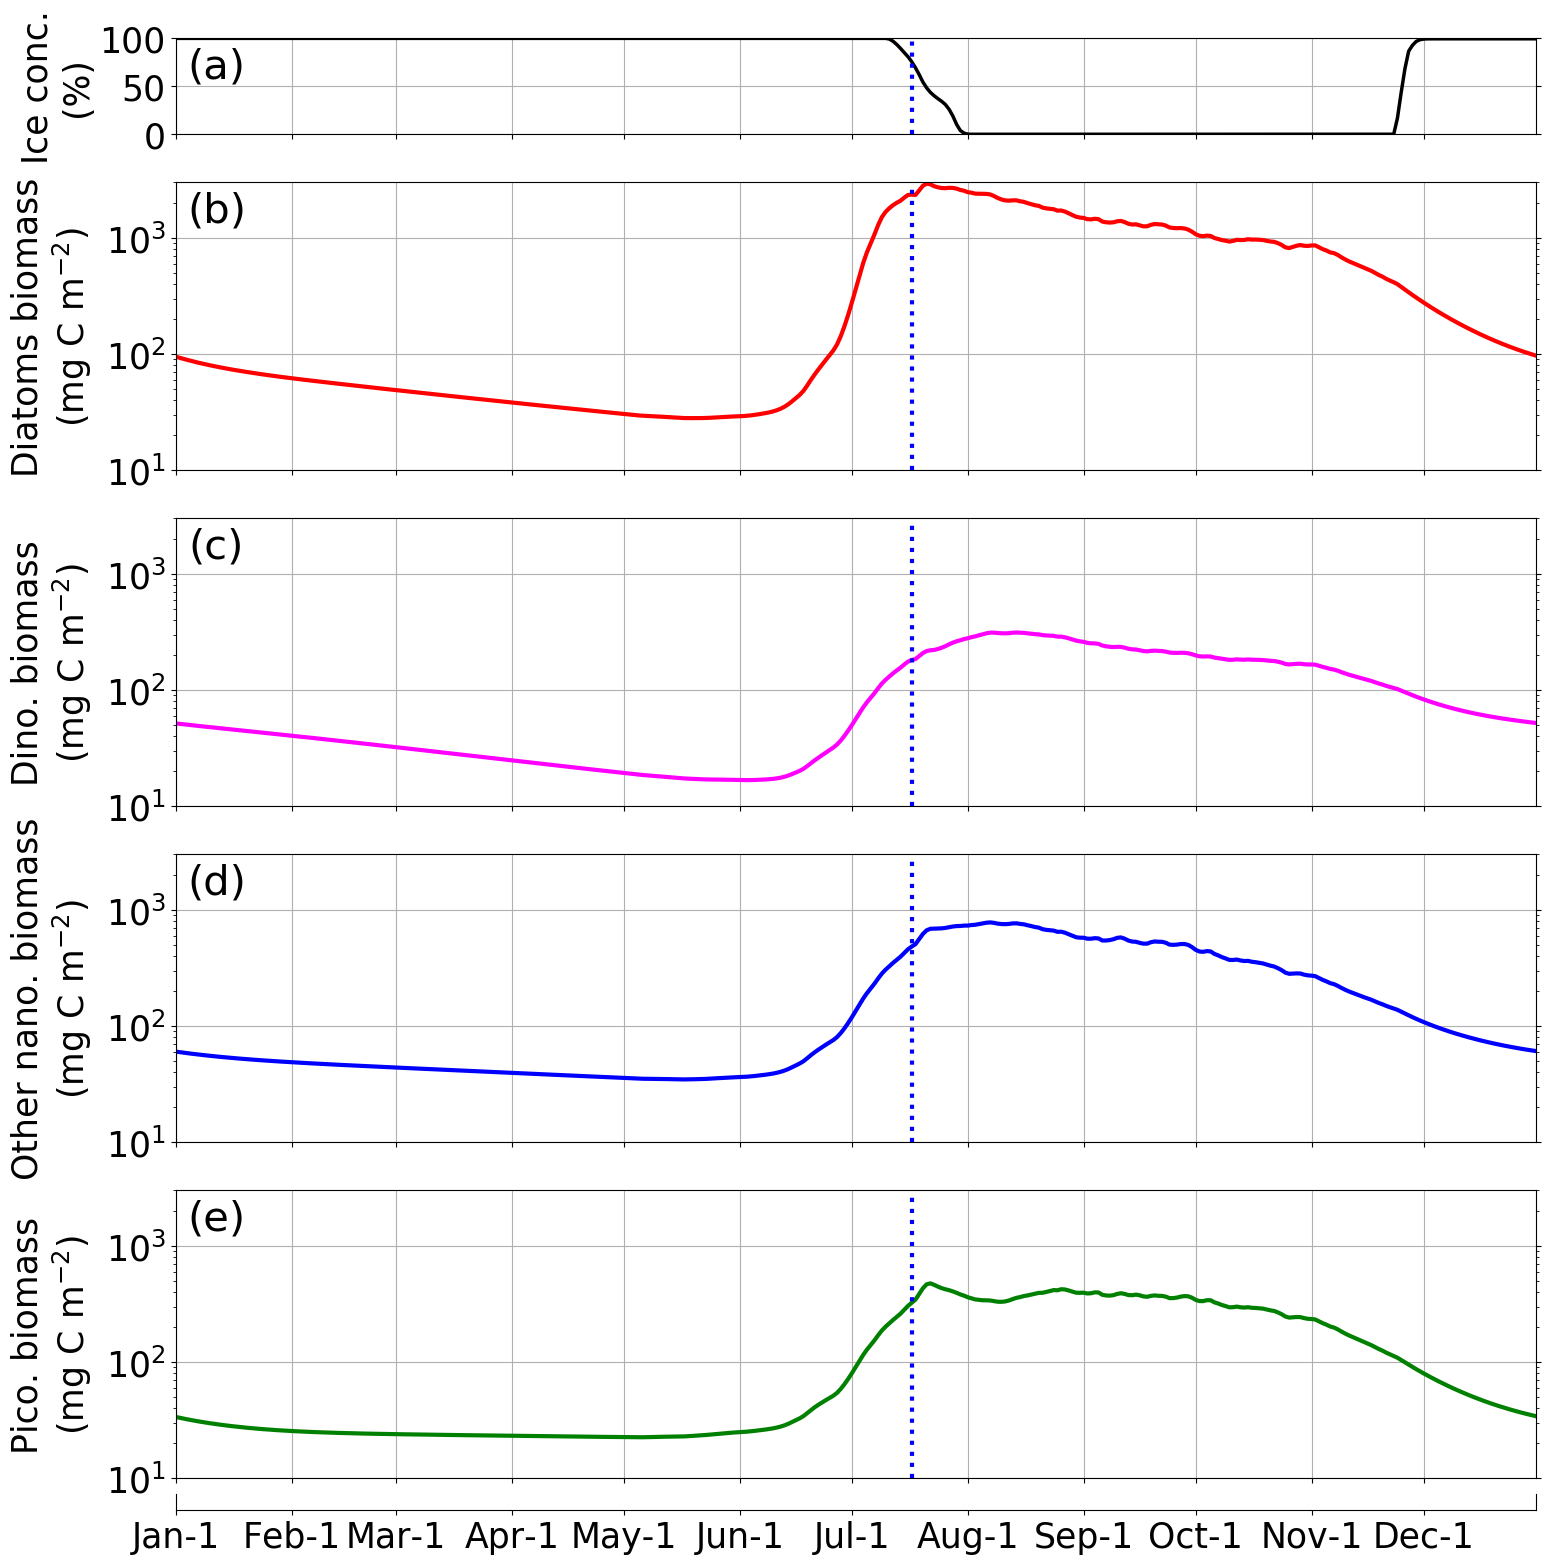

In [134]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n(%)',bbox=box)
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdiatomvint,
               '-',lw=3,color='red',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Diatoms biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(1E1,3E3)
    ax.grid()
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[2]
    h1=ax.plot(first_year,array1d_iT_simdinovint,
               '-',lw=3,color='magenta',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Dino. biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(1E1,3E3)
    ax.grid()
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER NANOEUKARYOTES
    ax=axs[3]
    h1=ax.plot(first_year,array1d_iT_simothervint,
               '-',lw=3,color='blue',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Other nano. biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(1E1,3E3)
    ax.grid()
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- PICOPHYTOPLANKTON
    ax=axs[4]
    h1=ax.plot(first_year,array1d_iT_simpicovint,
               '-',lw=3,color='green',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Pico. biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(1E1,3E3)
    ax.grid()
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[5]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.92  ,0.85,0.06])
    axs[1].set_position( [0.12,0.71  ,0.85,0.18])
    axs[2].set_position( [0.12,0.50  ,0.85,0.18])
    axs[3].set_position( [0.12,0.29  ,0.85,0.18])
    axs[4].set_position( [0.12,0.08  ,0.85,0.18])
    axs[5].set_position( [0.12,0.06  ,0.85,0.01])

with plt.style.context('many_rows_one_col.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(6,1,sharex=False,figsize=(16, 16))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.groups.vint100m.png')

In [135]:
plt.close('all')

## Simulation of biogeochemical functional groups: relative contribution ($\%$)

The relative contribution was calculated as a percentage of the biogeochemical functional group biomass vertically integrated (0-100m).

In [136]:
array1d_iT_simvint=array1d_iT_simdiatomvint+array1d_iT_simdinovint \
+array1d_iT_simothervint+array1d_iT_simpicovint

In [137]:
array1d_iT_simdiatomperc =array1d_iT_simdiatomvint/array1d_iT_simvint*100
array1d_iT_simdinoperc   =array1d_iT_simdinovint  /array1d_iT_simvint*100
array1d_iT_simotherperc  =array1d_iT_simothervint /array1d_iT_simvint*100
array1d_iT_simpicoperc   =array1d_iT_simpicovint  /array1d_iT_simvint*100

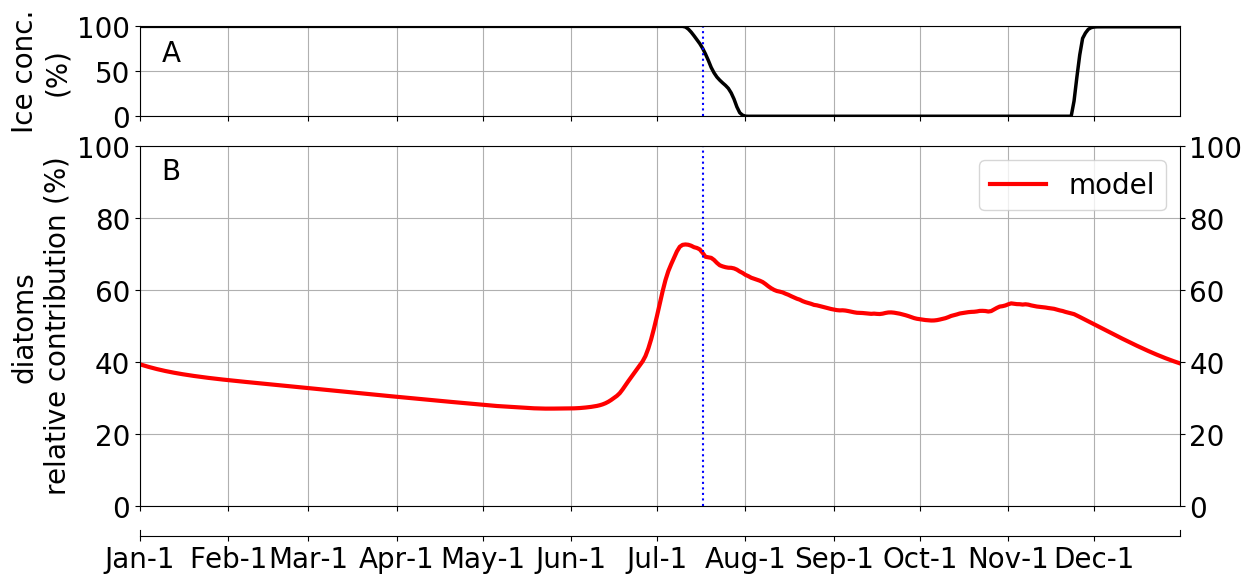

In [138]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdiatomperc,
               '-',lw=3,color='red',label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('diatoms\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.diatoms.percentage.png')

In [139]:
plt.close('all')

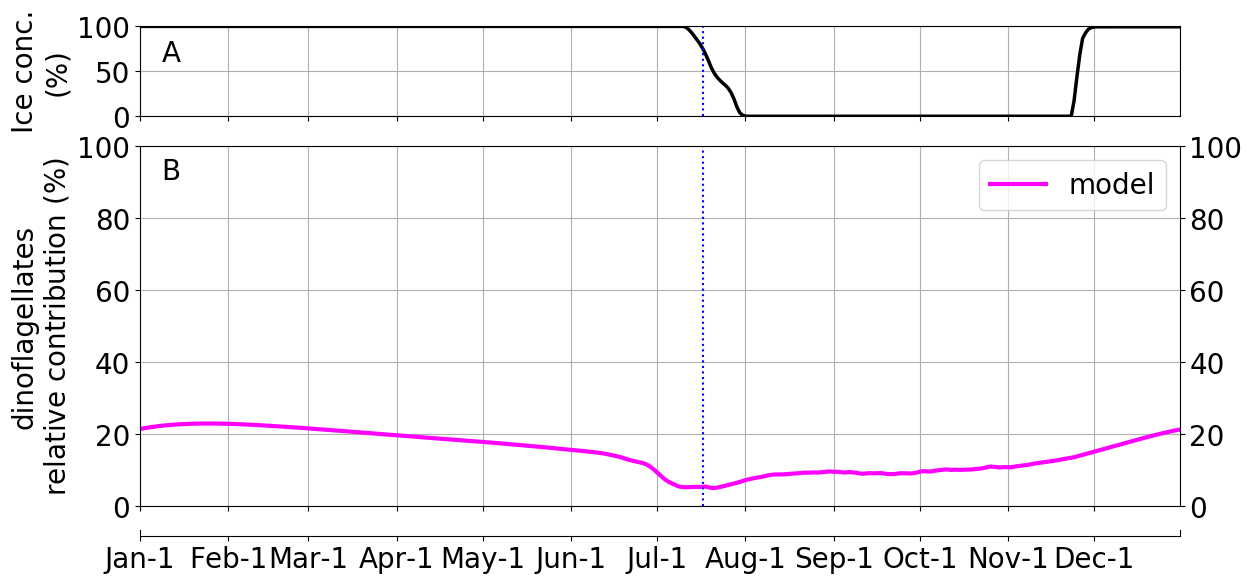

In [140]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdinoperc,
               '-',lw=3,color='magenta',label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('dinoflagellates\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.dino.percentage.png')

In [141]:
plt.close('all')

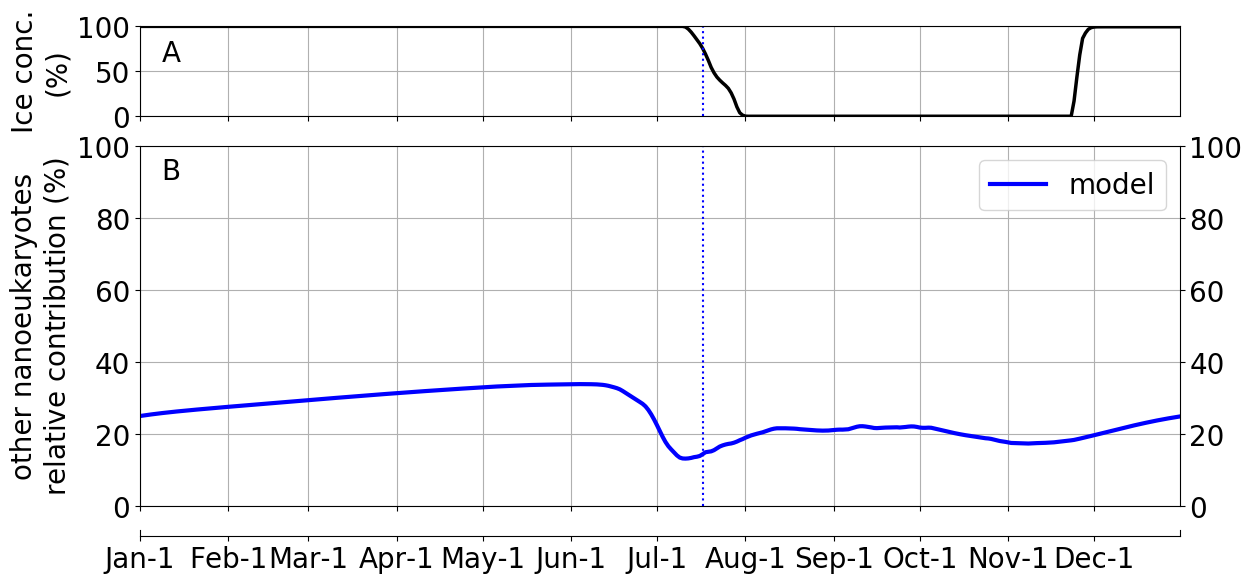

In [142]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER EUKARYOTES
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simotherperc,
               '-',lw=3,color='blue',label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('other nanoeukaryotes\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.other.percentage.png')

In [143]:
plt.close('all')

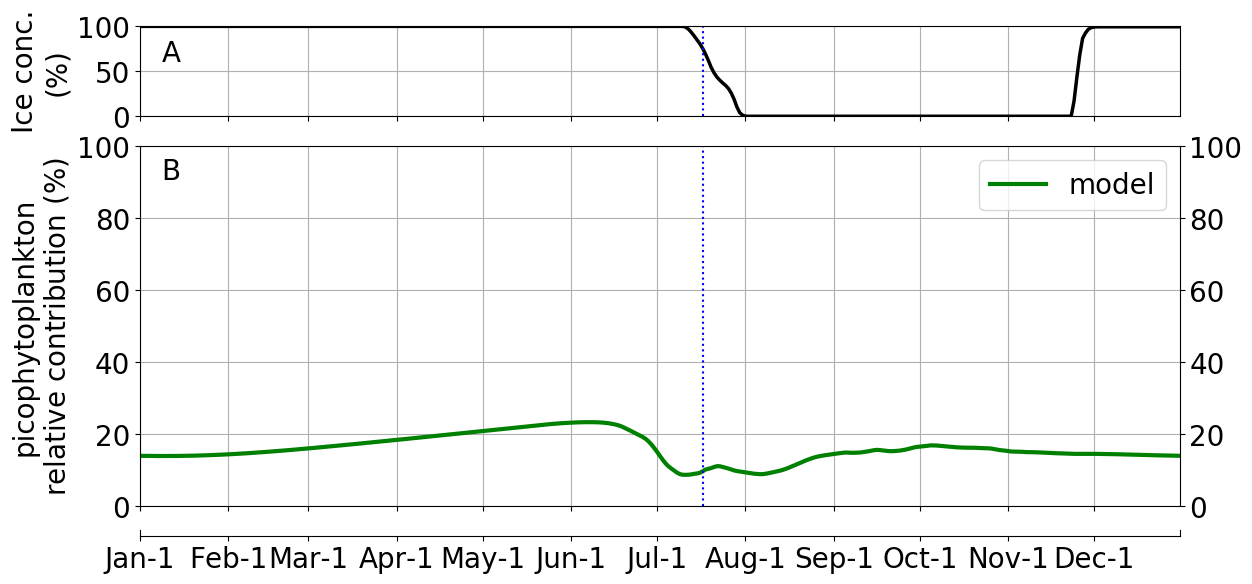

In [144]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIAZOTROPHS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simpicoperc,
               '-',lw=3,color='green',label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('picophytoplankton\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.pico.percentage.png')

In [145]:
plt.close('all')

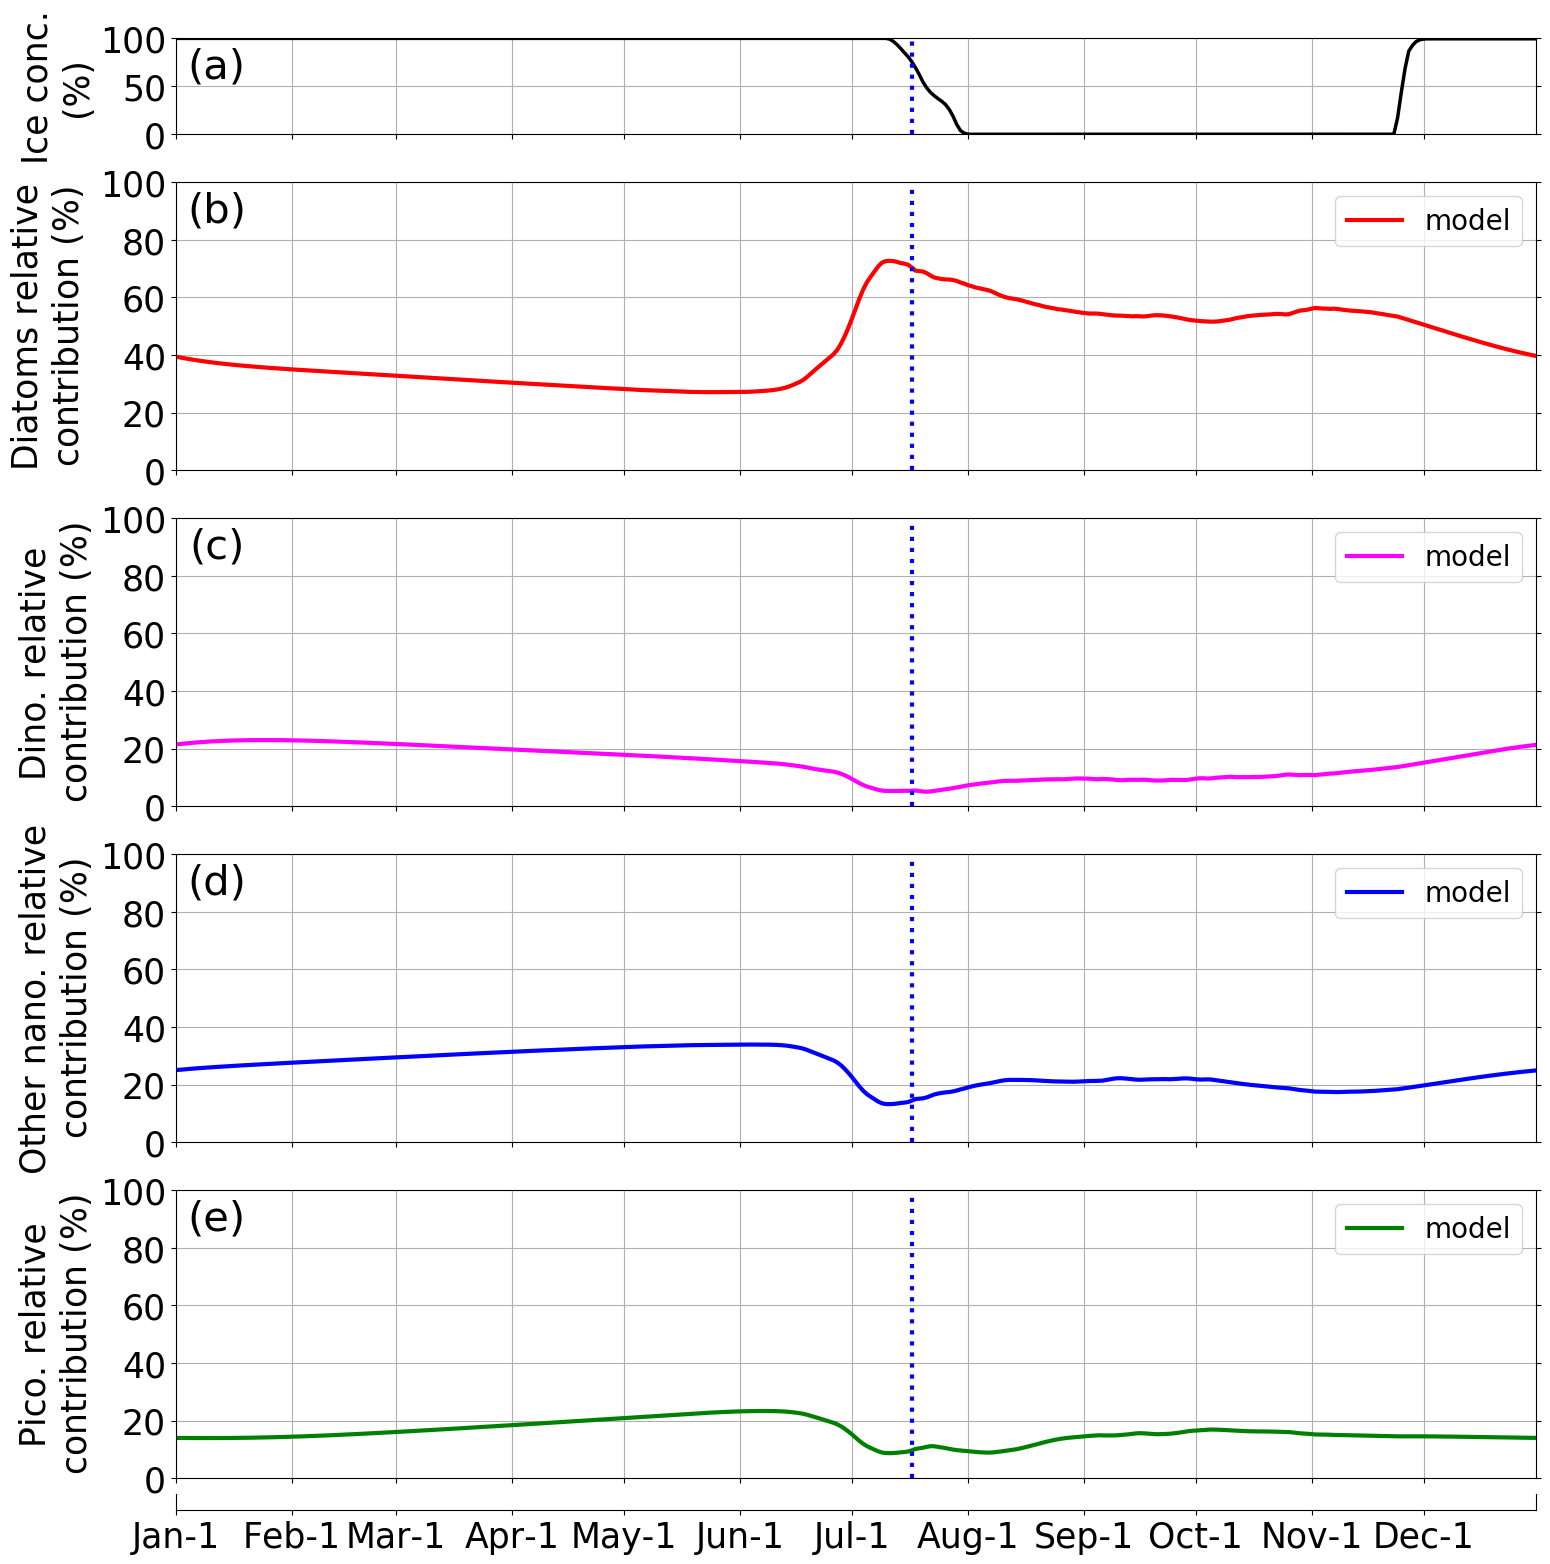

In [146]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n(%)',bbox=box)
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
#     ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdiatomperc,
               '-',lw=3,color='red',label='model')
#     h2=ax.plot(first_year,array1d1d_iT_obsdiatomperc,
#                'o',color='red',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Diatoms relative\ncontribution ($\%$)',bbox=box,
                 labelpad=10)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
#     ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[2]
    h1=ax.plot(first_year,array1d_iT_simdinoperc,
               '-',lw=3,color='magenta',label='model')
#     h2=ax.plot(first_year,array1d1d_iT_obsdinoperc,
#                'o',color='magenta',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Dino. relative\ncontribution ($\%$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
#     ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER EUKARYOTES
    ax=axs[3]
    h1=ax.plot(first_year,array1d_iT_simotherperc,
               '-',lw=3,color='blue',label='model')
#     h2=ax.plot(first_year,array1d1d_iT_obsotherperc,
#                'o',color='blue',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Other nano. relative\ncontribution ($\%$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
#     ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- PICOPHYTOPLANKTON
    ax=axs[4]
    h1=ax.plot(first_year,array1d_iT_simpicoperc,
               '-',lw=3,color='green',label='model')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Pico. relative\ncontribution ($\%$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
#     ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[5]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.92  ,0.85,0.06])
    axs[1].set_position( [0.12,0.71  ,0.85,0.18])
    axs[2].set_position( [0.12,0.50  ,0.85,0.18])
    axs[3].set_position( [0.12,0.29  ,0.85,0.18])
    axs[4].set_position( [0.12,0.08  ,0.85,0.18])
    axs[5].set_position( [0.12,0.06  ,0.85,0.01])

with plt.style.context('many_rows_one_col.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(6,1,sharex=False,figsize=(16, 16))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('car.0000000000.t001.year10.groups.percentage.png')

In [147]:
plt.close('all')

### Simulation of biogeochemical functional groups: relative contribution ($\%$): after the bloom peak

In [148]:
# g C m^-2
simvintafterpeak=np.array([simdiatomvintafterpeak,
                           simdinovintafterpeak,
                           simothervintafterpeak,
                           simpicovintafterpeak])

In [149]:
simtotalvintafterpeak=np.sum(simvintafterpeak)
simvintafterpeakp= \
[b/simtotalvintafterpeak*100 for b in simvintafterpeak]

In [150]:
diatoms_perc_afterpeak= \
simdiatomvintafterpeak/simtotalvintafterpeak*100

In [151]:
dino_perc_afterpeak= \
simdinovintafterpeak/simtotalvintafterpeak*100
other_perc_afterpeak= \
simothervintafterpeak/simtotalvintafterpeak*100
pico_perc_afterpeak= \
simpicovintafterpeak/simtotalvintafterpeak*100

In [152]:
df=pd.DataFrame({
    'diatoms_biomass_afterpeak_gCm2':[simdiatomvintafterpeak],
    'dino_biomass_afterpeak_gCm2'   :[simdinovintafterpeak],
    'other_biomass_afterpeak_gCm2'  :[simothervintafterpeak],
    'pico_biomass_afterpeak_gCm2'   :[simpicovintafterpeak],
    'total_biomass_afterpeak_gCm2'  :[simtotalvintafterpeak],
    'diatoms_perc_afterpeak'        :[diatoms_perc_afterpeak],
    'dino_perc_afterpeak'           :[dino_perc_afterpeak],
    'other_perc_afterpeak'          :[other_perc_afterpeak],
    'pico_perc_afterpeak'           :[pico_perc_afterpeak]
})
outfile='groups_after_peak.csv'
df.to_csv(outfile,index=False)

In [153]:
outfile_long='groups_after_peak.'+os.path.basename(os.getcwd())+'.csv'
shutil.copy(outfile,outfile_long)

'groups_after_peak.run_20230707_0000_EXP0_translucent_snow.csv'

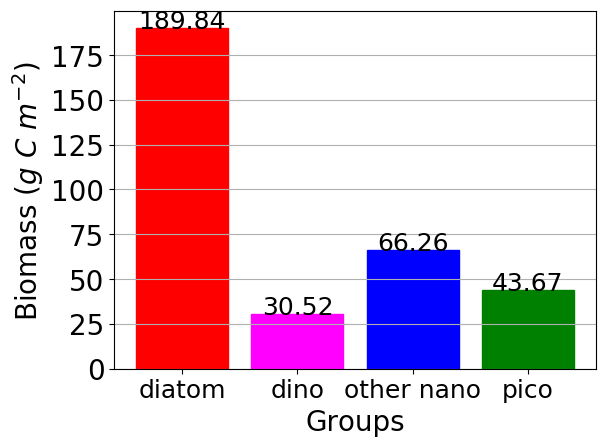

In [154]:
with plt.style.context('barplot.mplstyle'):
    names=['diatom','dino','other nano','pico']
    my_colors=['red','magenta','blue','green']
    fig, ax = plt.subplots()
    # mg C m^-2 -> g C m^-2
    simvintafterpeakgc=simvintafterpeak
    barlist=ax.bar(names,simvintafterpeakgc)
    ax.set_xlabel('Groups')
    ax.set_ylabel('Biomass ($g\ C\ m^{-2}$)')
    ax.grid(axis='y')
#     ax.set_ylim(0,100)
    for i,rect in enumerate(barlist):
        rect.set_color(my_colors[i])
    for index, b in enumerate(simvintafterpeakgc):
        plt.text(index,b,str(round(b,2)),ha='center')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.lastyear.biomass.afterpeak.png')

In [155]:
plt.close('all')

Figure. Simulated biomass of biogeochemical functional groups vertically integrated (0-100m) and temporally integrated after the bloom peak ($g\ C\ m^{-2}$). dino: mixotrophic dinoflagellates. other nano: other nanoeukaryotes. pico: picophytoplankton.

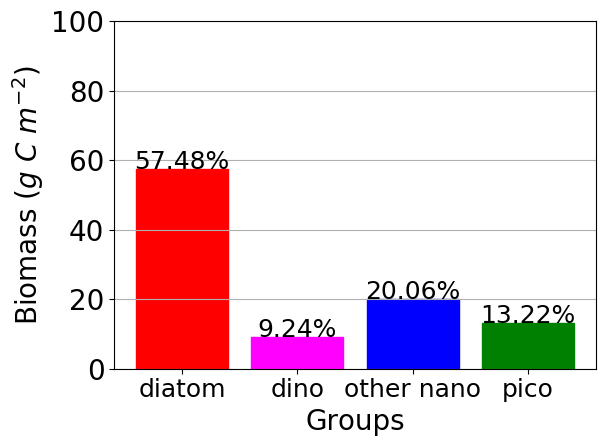

In [156]:
with plt.style.context('barplot.mplstyle'):
    names=['diatom','dino','other nano','pico']
    my_colors=['red','magenta','blue','green']
    fig, ax = plt.subplots()
    barlist=ax.bar(names,simvintafterpeakp)
    ax.set_xlabel('Groups')
    ax.set_ylabel('Biomass ($g\ C\ m^{-2}$)')
    ax.grid(axis='y')
    ax.set_ylim(0,100)
    for i,rect in enumerate(barlist):
        rect.set_color(my_colors[i])
    for index, b in enumerate(simvintafterpeakp):
        plt.text(index,b,str(round(b,2))+'%',ha='center')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.lastyear.percentage.afterpeak.png')

In [157]:
plt.close('all')

Figure. Relative contribution of the simulated biomass of the biogeochemical functional groups vertically integrated (0-100m) and temporally integrated after the bloom peak ($\%$). dino: mixotrophic dinoflagellates. other nano: other nanoeukaryotes. pico: picophytoplankton.

### Simulation of biogeochemical functional groups: relative contribution ($\%$): whole year

In [158]:
# g C m^-2
simvint=np.array([simdiatomvint,
                  simdinovint,
                  simothervint,
                  simpicovint])

In [159]:
simtotalvint=np.sum(simvint)
simvintp= \
[b/simtotalvint*100 for b in simvint]

In [160]:
diatoms_perc= \
simdiatomvint/simtotalvint*100

In [161]:
dino_perc= \
simdinovint/simtotalvint*100
other_perc= \
simothervint/simtotalvint*100
pico_perc= \
simpicovint/simtotalvint*100

In [162]:
df=pd.DataFrame({
    'diatoms_biomass_gCm2':[simdiatomvint],
    'dino_biomass_gCm2'   :[simdinovint],
    'other_biomass_gCm2'  :[simothervint],
    'pico_biomass_gCm2'   :[simpicovint],
    'total_biomass_gCm2'  :[simtotalvint],
    'diatoms_perc'        :[diatoms_perc],
    'dino_perc'           :[dino_perc],
    'other_perc'          :[other_perc],
    'pico_perc'           :[pico_perc]
})
outfile='groups.csv'
df.to_csv(outfile,index=False)

In [163]:
outfile_long='groups.'+os.path.basename(os.getcwd())+'.csv'
shutil.copy(outfile,outfile_long)

'groups.run_20230707_0000_EXP0_translucent_snow.csv'

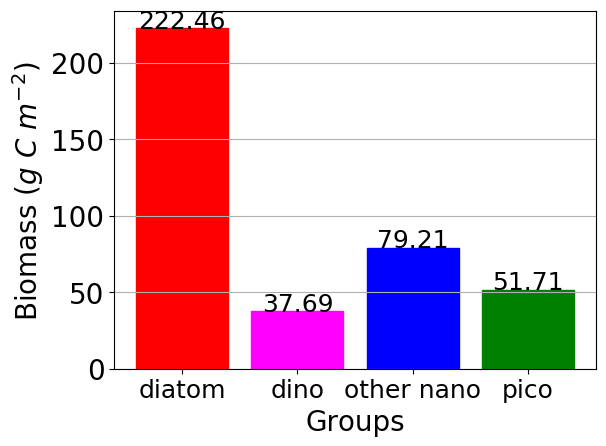

In [164]:
with plt.style.context('barplot.mplstyle'):
    names=['diatom','dino','other nano','pico']
    my_colors=['red','magenta','blue','green']
    fig, ax = plt.subplots()
    # mg C m^-2 -> g C m^-2
    simvintgc=simvint
    barlist=ax.bar(names,simvintgc)
    ax.set_xlabel('Groups')
    ax.set_ylabel('Biomass ($g\ C\ m^{-2}$)')
    ax.grid(axis='y')
#     ax.set_ylim(0,100)
    for i,rect in enumerate(barlist):
        rect.set_color(my_colors[i])
    for index, b in enumerate(simvintgc):
        plt.text(index,b,str(round(b,2)),ha='center')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.lastyear.biomass.png')

In [165]:
plt.close('all')

Figure. Simulated biomass of biogeochemical functional groups vertically integrated (0-100m) and temporally integrated ($g\ C\ m^{-2}$). dino: mixotrophic dinoflagellates. other nano: other nanoeukaryotes. pico: picophytoplankton.

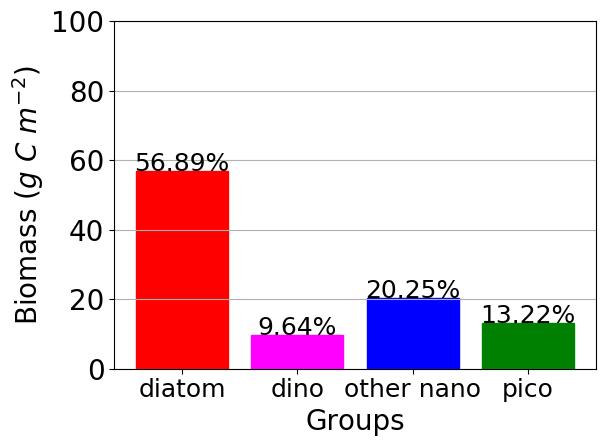

In [166]:
with plt.style.context('barplot.mplstyle'):
    names=['diatom','dino','other nano','pico']
    my_colors=['red','magenta','blue','green']
    fig, ax = plt.subplots()
    barlist=ax.bar(names,simvintp)
    ax.set_xlabel('Groups')
    ax.set_ylabel('Biomass ($g\ C\ m^{-2}$)')
    ax.grid(axis='y')
    ax.set_ylim(0,100)
    for i,rect in enumerate(barlist):
        rect.set_color(my_colors[i])
    for index, b in enumerate(simvintp):
        plt.text(index,b,str(round(b,2))+'%',ha='center')
    plt.tight_layout()
    plt.savefig('car.0000000000.t001.lastyear.percentage.png')

In [167]:
plt.close('all')

Figure. Relative contribution of the simulated biomass of the biogeochemical functional groups vertically integrated (0-100m) and temporally integrated ($\%$). dino: mixotrophic dinoflagellates. other nano: other nanoeukaryotes. pico: picophytoplankton.

# Comparion between observations and simulation

## Comparion between observations and simulation: biomass ($mg\ C\ m^{-3}$)

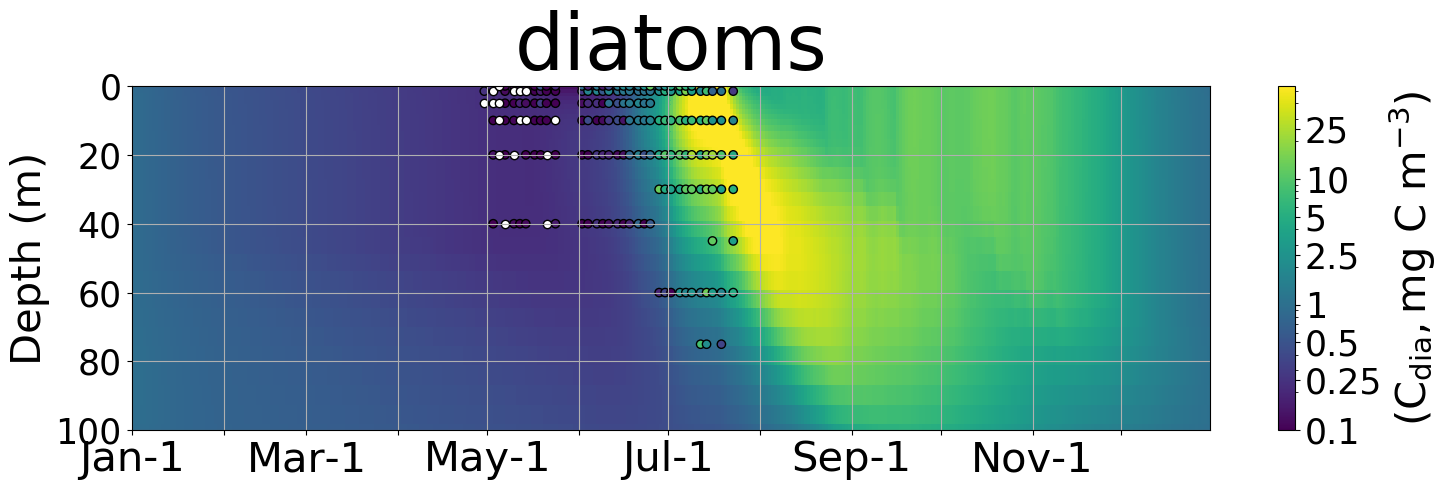

In [168]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simdiatom,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    hc=ax.scatter(diatomsobs_df['doy']-1,
                  -diatomsobs_df['depth'],
                  c=diatomsobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(diatomsnoobs['doy']-1,
                  -diatomsnoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('diatoms')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (C_{dia}, mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.comp.diatoms.m3.png')

In [169]:
plt.close('all')

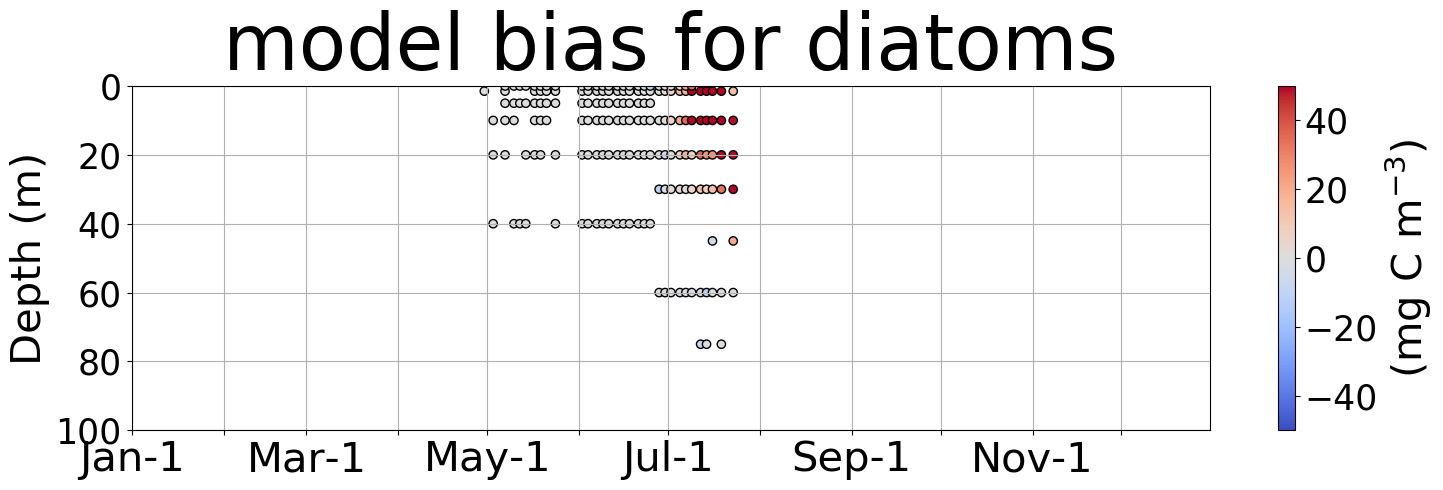

In [170]:
assert simdiatom_df['doy'].equals(diatomsobs_df['doy']), \
"column doy in simdiatom_df is different from column doy in diatoms_df"
assert simdiatom_df['depth'].equals(diatomsobs_df['depth']), \
"column depth in simdiatom_df is different from column depth in diatoms_df"
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(simdiatom_df['doy']-1,
                  -simdiatom_df['depth'],
                  c=simdiatom_df['carbon_estimate_mg_c_m3'] \
                  -diatomsobs_df['carbon_estimate_mg_c_m3'],
                  cmap='coolwarm',
                  vmin=-50,
                  vmax=50,
                  s=None,
                  edgecolor='k')
    ax.set_title('model bias for diatoms')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.bias.diatoms.m3.png')

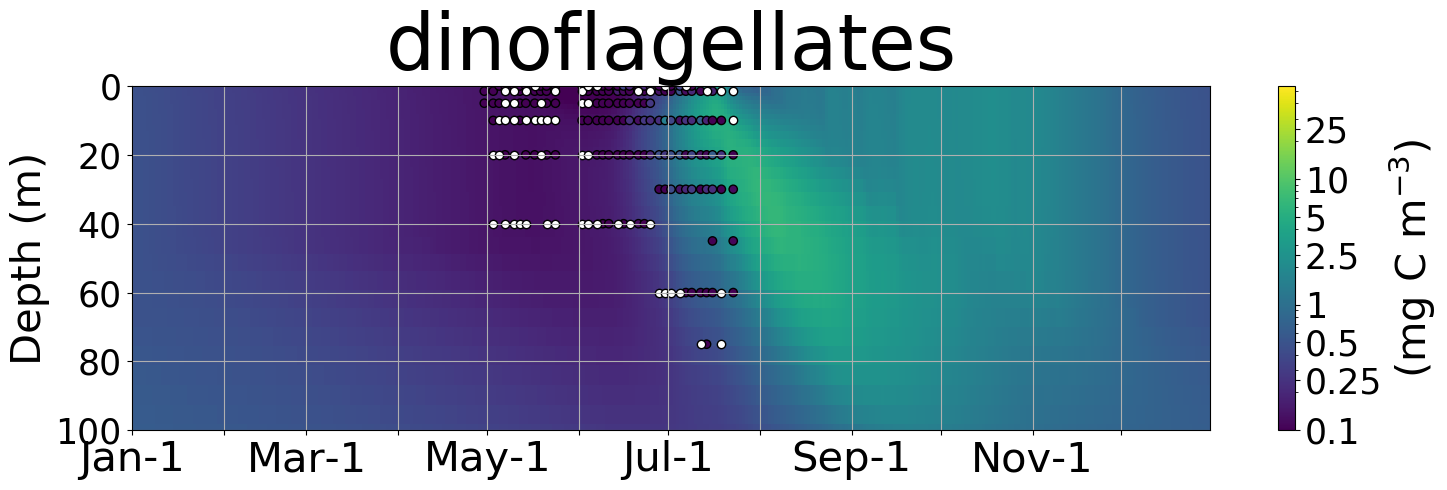

In [171]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simdino,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    hc=ax.scatter(dinoobs_df['doy']-1,
                  -dinoobs_df['depth'],
                  c=dinoobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(dinonoobs['doy']-1,
                  -dinonoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('dinoflagellates')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.comp.dino.m3.png')

In [172]:
plt.close('all')

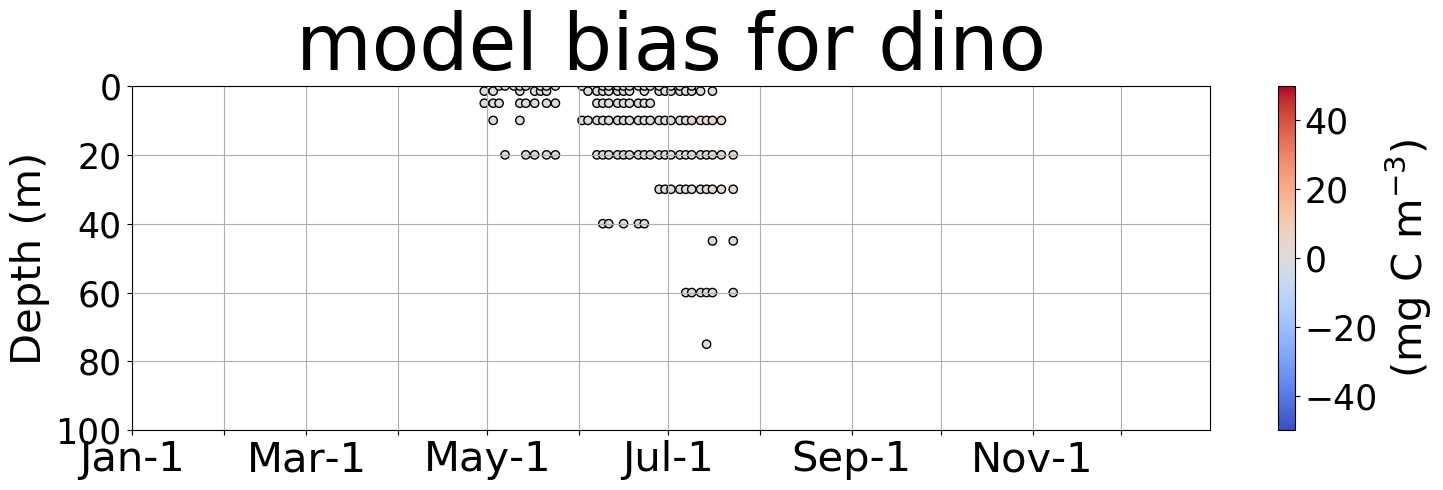

In [173]:
assert simdino_df['doy'].equals(dinoobs_df['doy']), \
"column doy in simdino_df is different from column doy in dino_df"
assert simdino_df['depth'].equals(dinoobs_df['depth']), \
"column depth in dino_df is different from column depth in dino_df"
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(simdino_df['doy']-1,
                  -simdino_df['depth'],
                  c=simdino_df['carbon_estimate_mg_c_m3'] \
                  -dinoobs_df['carbon_estimate_mg_c_m3'],
                  cmap='coolwarm',
                  vmin=-50,
                  vmax=50,
                  s=None,
                  edgecolor='k')
    ax.set_title('model bias for dino')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.bias.dino.m3.png')

In [174]:
plt.close('all')

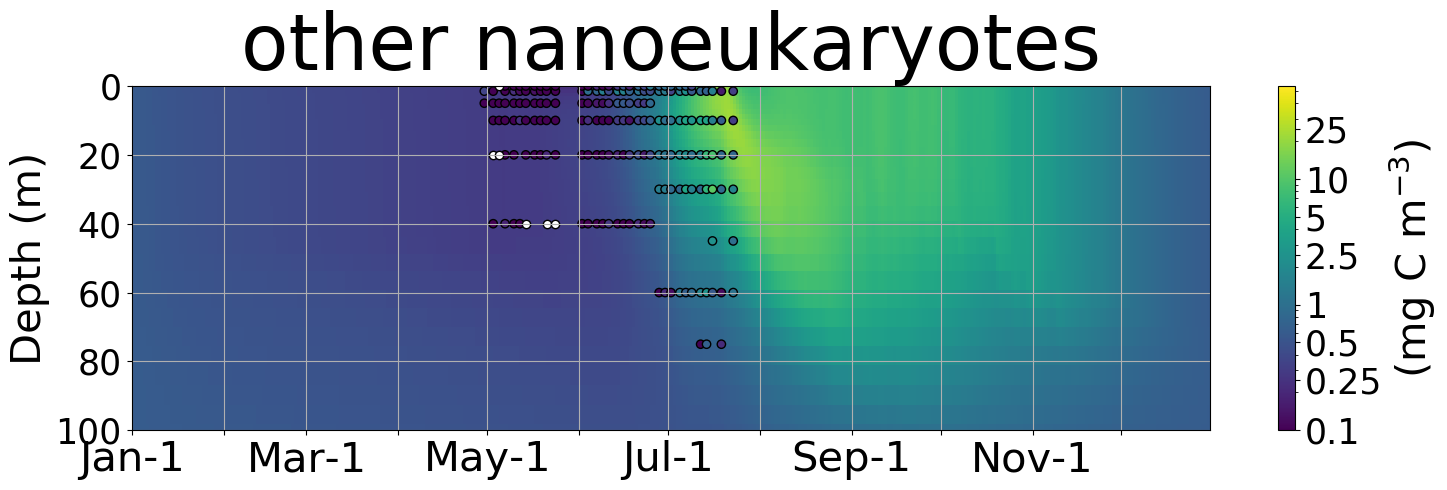

In [175]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simother,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    hc=ax.scatter(otherobs_df['doy']-1,
                  -otherobs_df['depth'],
                  c=otherobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(othernoobs['doy']-1,
                  -othernoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_title('other nanoeukaryotes')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.comp.other.m3.png')

In [176]:
plt.close('all')

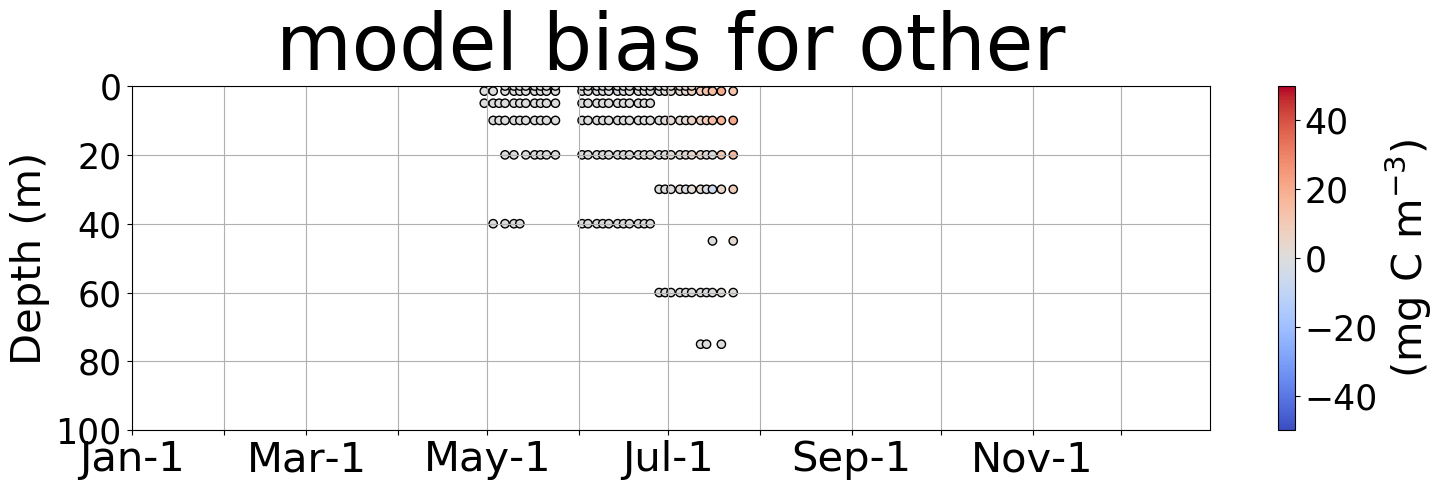

In [177]:
assert simother_df['doy'].equals(otherobs_df['doy']), \
"column doy in simother_df is different from column doy in other_df"
assert simother_df['depth'].equals(otherobs_df['depth']), \
"column depth in other_df is different from column depth in other_df"
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                   181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.scatter(simother_df['doy']-1,
                  -simother_df['depth'],
                  c=simother_df['carbon_estimate_mg_c_m3'] \
                  -otherobs_df['carbon_estimate_mg_c_m3'],
                  cmap='coolwarm',
                  vmin=-50,
                  vmax=50,
                  s=None,
                  edgecolor='k')
    ax.set_title('model bias for other')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.bias.other.m3.png')

In [178]:
plt.close('all')

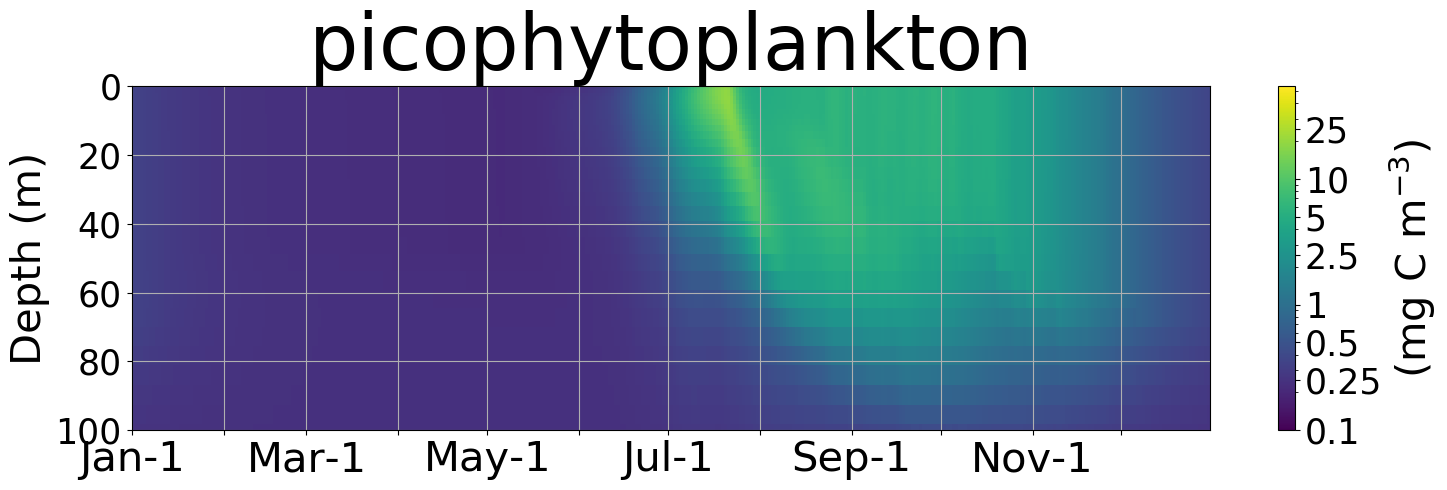

In [179]:
with plt.style.context('noice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','','Mar-1','','May-1','',
            'Jul-1','','Sep-1','','Nov-1','')
    RF_above105=RF[RF>-105]
    plt.figure(figsize=(15,5))
    ax = plt.gca()
    hc=ax.pcolormesh(first_year366,
                     -RF_above105,
                     array2d_idepth_iT_simpico,
                     norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                    )
    ax.set_title('picophytoplankton')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbar=plt.colorbar(hc)
    cticks=[0.1,0.25,0.5,1,2.5,5,10,25]
    cbar.set_ticks(cticks)
    cbar.set_ticklabels(cticks)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.tight_layout()
    plt.savefig('validation/GEic2016.comp.pico.m3.png')

In [180]:
plt.close('all')

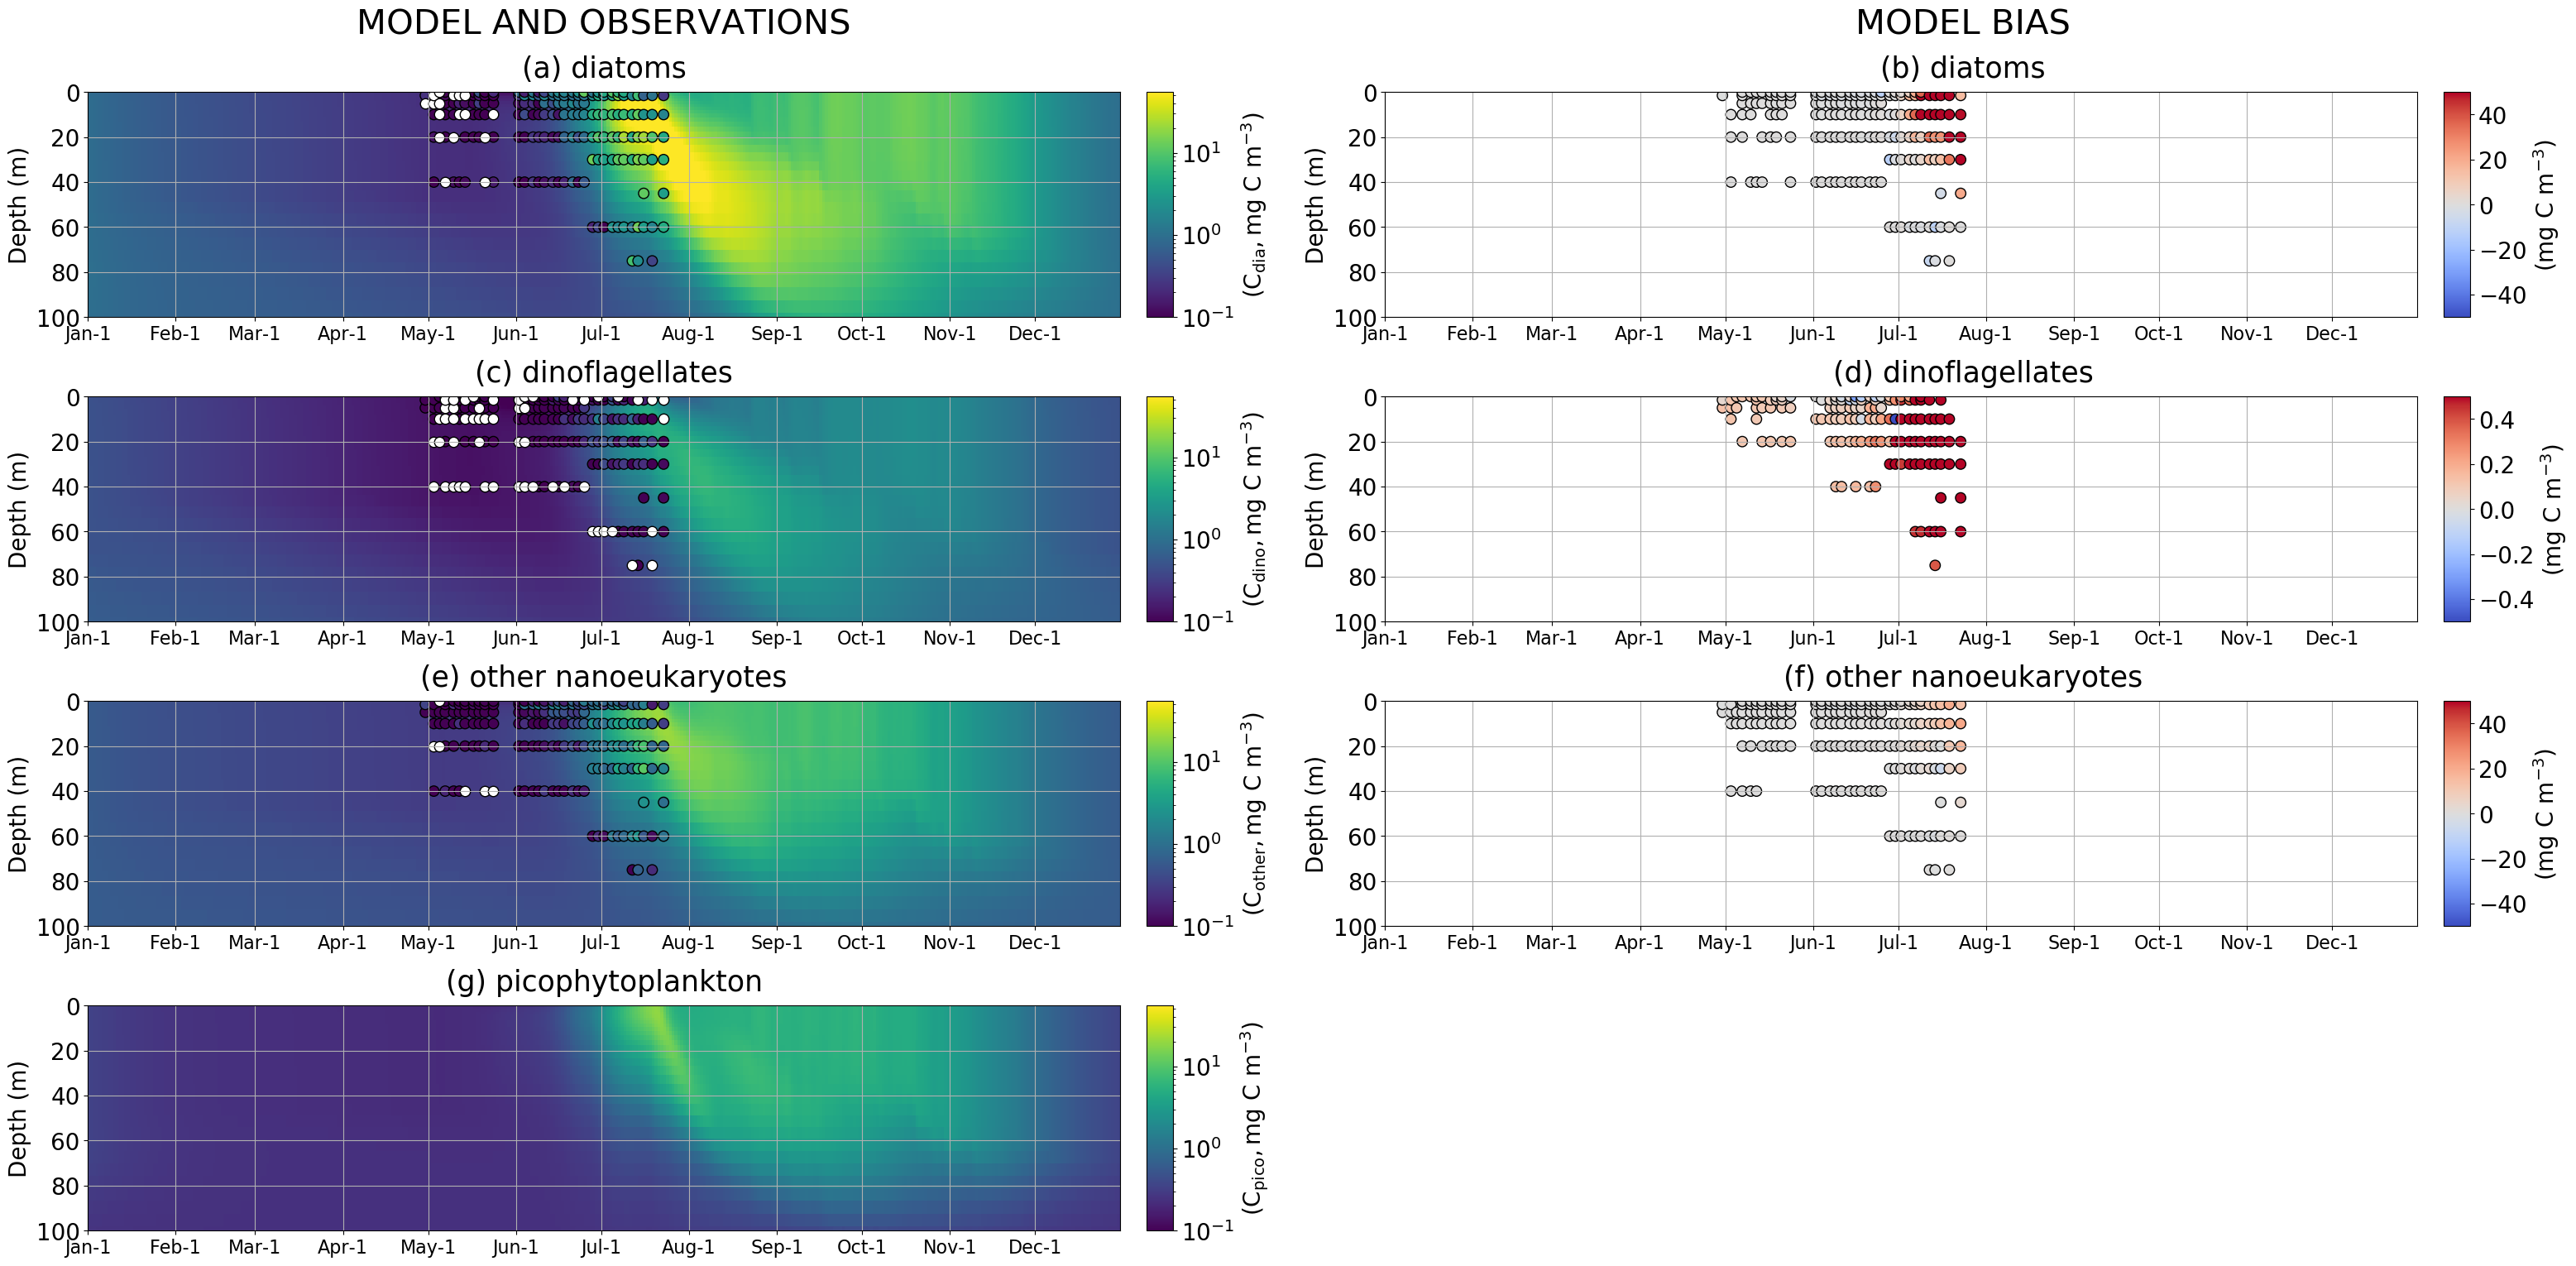

In [181]:
with plt.style.context('GEic2016.m3.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    fig,axs=plt.subplots(nrows=4,ncols=2,figsize=(32, 16))

    # --- DIATOMS: MODEL AND OBSERVATIONS
    ax=axs[0,0]
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simdiatom,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    hc=ax.scatter(diatomsobs_df['doy']-1,
                  -diatomsobs_df['depth'],
                  c=diatomsobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(diatomsnoobs['doy']-1,
                  -diatomsnoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.45, 0.74, 0.01, 0.17])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (C_{dia}, mg\ C\ m^{-3}) }$')
    plt.text(0.50,1.10,'(a) diatoms',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )
    plt.text(0.50,1.30,'MODEL AND OBSERVATIONS',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes,
             fontsize=30
            )

    # --- DIATOMS: MODEL BIAS
    ax=axs[0,1]
    hc=ax.scatter(simdiatom_df['doy']-1,
                  -simdiatom_df['depth'],
                  c=simdiatom_df['carbon_estimate_mg_c_m3'] \
                  -diatomsobs_df['carbon_estimate_mg_c_m3'],
                  cmap='coolwarm',
                  vmin=-50,
                  vmax=50,
                  s=None,
                  edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbaxes = fig.add_axes([0.94, 0.74, 0.01, 0.17])
    cbar=plt.colorbar(hc,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.text(0.56,1.10,'(b) diatoms',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )
    plt.text(0.56,1.30,'MODEL BIAS',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes,
             fontsize=30
            )

    # --- DINOFLAGELLATES: MODEL AND OBSERVATIONS
    ax=axs[1,0]
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simdino,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    hc=ax.scatter(dinoobs_df['doy']-1,
                  -dinoobs_df['depth'],
                  c=dinoobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(dinonoobs['doy']-1,
                  -dinonoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.45, 0.51, 0.01, 0.17])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (C_{dino}, mg\ C\ m^{-3}) }$')
    plt.text(0.50,1.10,'(c) dinoflagellates',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )

    # --- DINOFLAGELLATES: MODEL BIAS
    ax=axs[1,1]
    hc=ax.scatter(simdino_df['doy']-1,
                  -simdino_df['depth'],
                  c=simdino_df['carbon_estimate_mg_c_m3'] \
                  -dinoobs_df['carbon_estimate_mg_c_m3'],
                  cmap='coolwarm',
                  vmin=-0.5,
                  vmax=0.5,
                  s=None,
                  edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbaxes = fig.add_axes([0.94, 0.51, 0.01, 0.17])
    cbar=plt.colorbar(hc,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.text(0.56,1.10,'(d) dinoflagellates',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )

    # --- OTHER NANOEUKARYOTES: MODEL AND OBSERVATIONS
    ax=axs[2,0]
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simother,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    hc=ax.scatter(otherobs_df['doy']-1,
                  -otherobs_df['depth'],
                  c=otherobs_df['carbon_estimate_mg_c_m3'],
                  norm=mpl.colors.LogNorm(vmin=0.1,vmax=55),
                  edgecolor='k')
    hw=ax.scatter(othernoobs['doy']-1,
                  -othernoobs['depth'],
                  c='white',
                  edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.45, 0.28, 0.01, 0.17])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (C_{other}, mg\ C\ m^{-3}) }$')
    plt.text(0.50,1.10,'(e) other nanoeukaryotes',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )

    # --- OTHER NANOEUKARYOTES: MODEL BIAS
    ax=axs[2,1]
    hc=ax.scatter(simother_df['doy']-1,
                  -simother_df['depth'],
                  c=simother_df['carbon_estimate_mg_c_m3'] \
                  -otherobs_df['carbon_estimate_mg_c_m3'],
                  cmap='coolwarm',
                  vmin=-50,
                  vmax=50,
                  s=None,
                  edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbaxes = fig.add_axes([0.94, 0.28, 0.01, 0.17])
    cbar=plt.colorbar(hc,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (mg\ C\ m^{-3}) }$')
    plt.text(0.56,1.10,'(f) other nanoeukaryotes',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )

    # --- PICOPHYTOPLANKTON: MODEL ONLY
    ax=axs[3,0]
    h=ax.pcolormesh(first_year366,
                    -RF_above105,
                    array2d_idepth_iT_simpico,
                    norm=mpl.colors.LogNorm(vmin=0.1,vmax=55)
                  )
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(0,100)
    ax.invert_yaxis()
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.set_yticks([0,20,40,60,80,100])
    cbaxes = fig.add_axes([0.45, 0.05, 0.01, 0.17])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('$\mathrm{ (C_{pico}, mg\ C\ m^{-3}) }$')
    plt.text(0.50,1.10,'(g) picophytoplankton',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes, fontsize=25
            )

    # --- NOTHING
    ax=axs[3,1]
    ax.axis('off')

    # --- POSITION
    axs[0,0].set_position( [0.05,0.74  ,0.39,0.17])
    axs[0,1].set_position( [0.54,0.74  ,0.39,0.17])
    axs[1,0].set_position( [0.05,0.51  ,0.39,0.17])
    axs[1,1].set_position( [0.54,0.51  ,0.39,0.17])
    axs[2,0].set_position( [0.05,0.28  ,0.39,0.17])
    axs[2,1].set_position( [0.54,0.28  ,0.39,0.17])
    axs[3,0].set_position( [0.05,0.05  ,0.39,0.17])
    axs[3,1].set_position( [0.54,0.05  ,0.39,0.17])

    # --- SAVE
    plt.savefig('validation/GEic2016.groups.m3.png')

In [182]:
plt.close('all')

## Comparison between observations and simulation: vertically integrated biomass ($0-100\ m$; $mg\ C\ m^{-2}$)

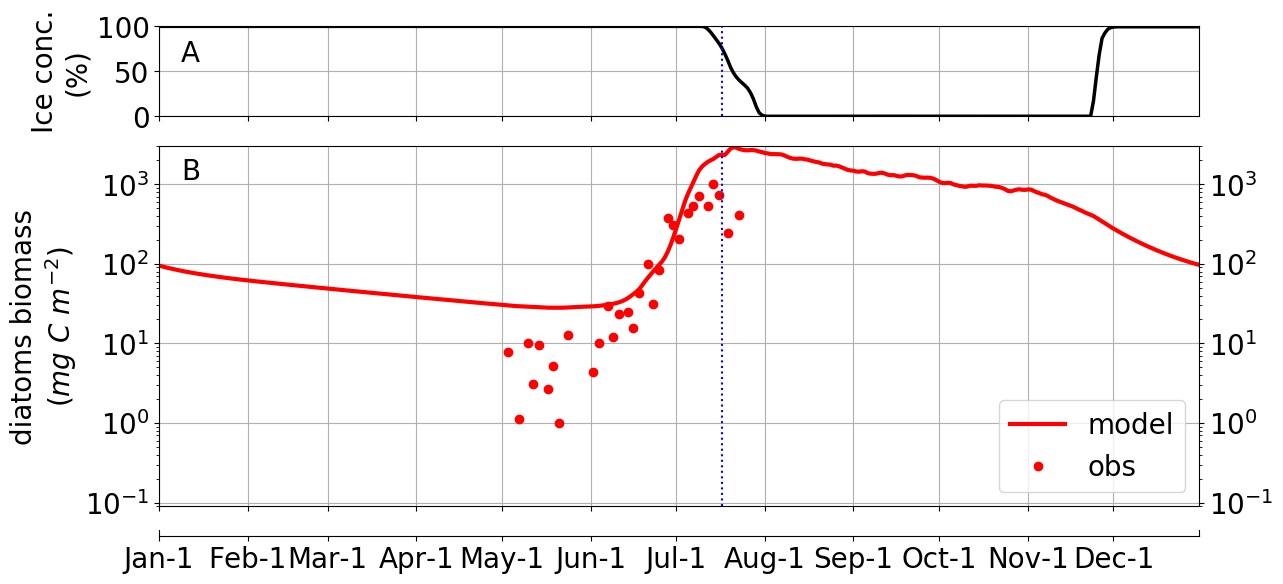

In [183]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdiatomvint,
               '-',lw=3,color='red',label='model')
    h2=ax.plot(first_year,array1d_iT_obsdiatomvint,
               'o',color='red',label='obs')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('diatoms biomass\n($mg\ C\ m^{-2}$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.diatoms.vint100m.png')

In [184]:
plt.close('all')

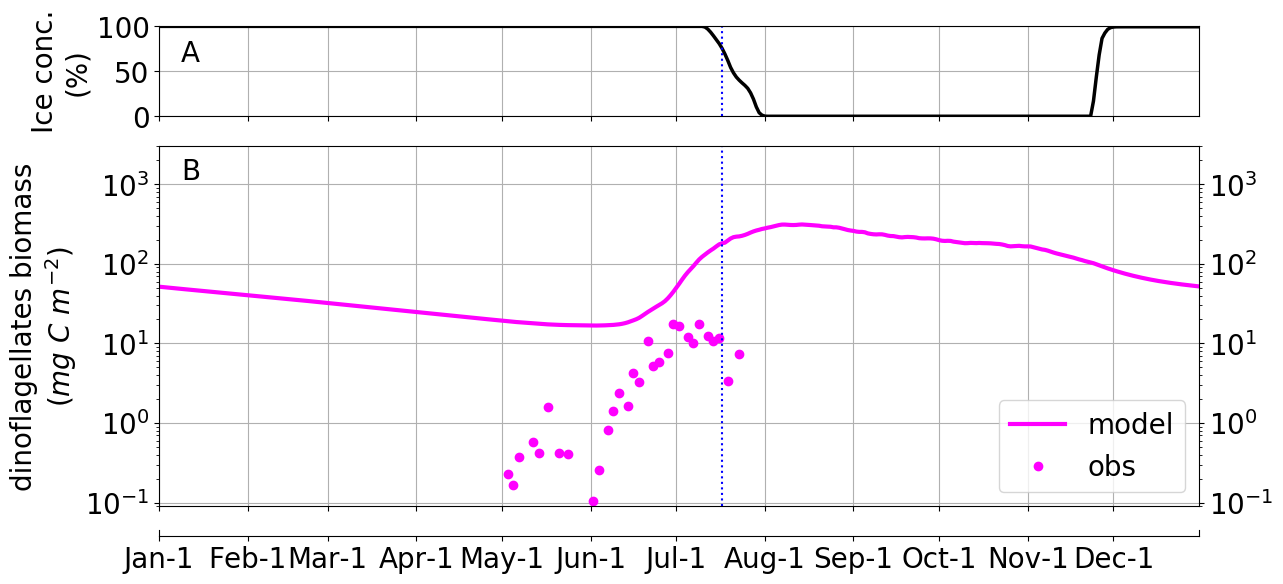

In [185]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdinovint,
               '-',lw=3,color='magenta',label='model')
    h2=ax.plot(first_year,array1d_iT_obsdinovint,
               'o',color='magenta',label='obs')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('dinoflagellates biomass\n($mg\ C\ m^{-2}$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.dino.vint100m.png')

In [186]:
plt.close('all')

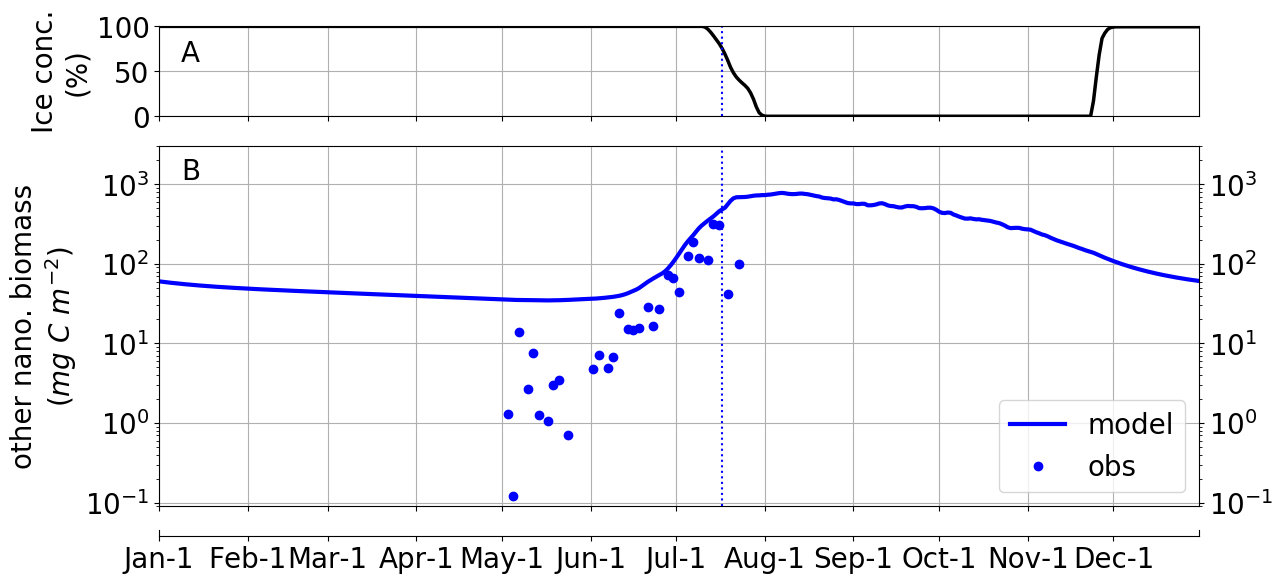

In [187]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER NANOEUKARYOTES
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simothervint,
               '-',lw=3,color='blue',label='model')
    h2=ax.plot(first_year,array1d_iT_obsothervint,
               'o',color='blue',label='obs')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('other nano. biomass\n($mg\ C\ m^{-2}$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.other.vint100m.png')

In [188]:
plt.close('all')

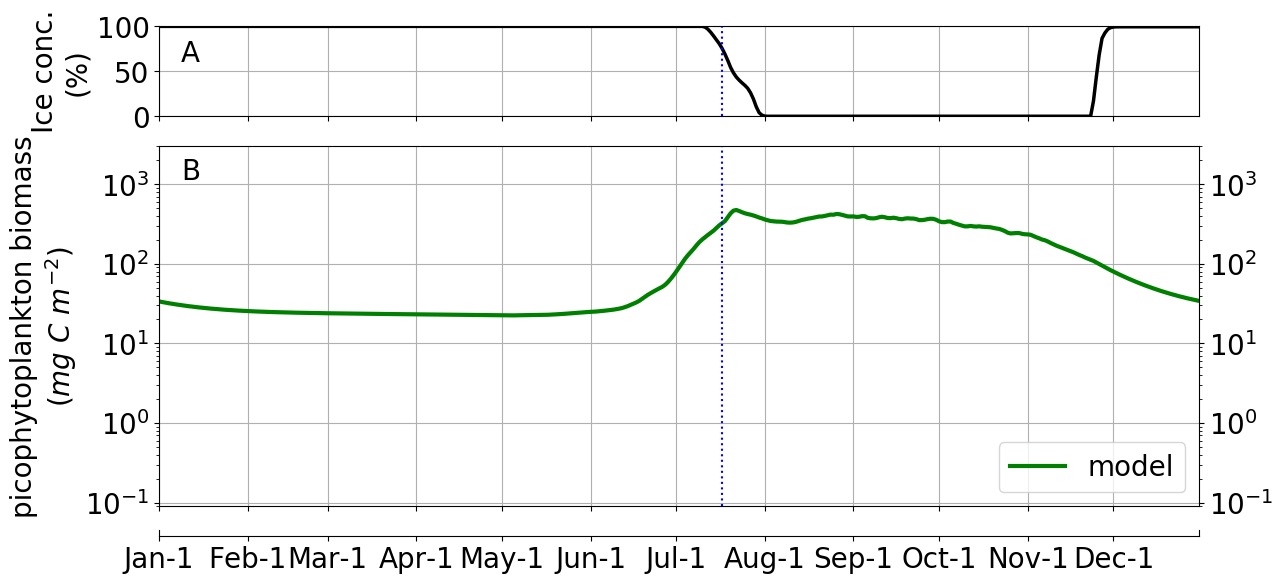

In [189]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIAZOTROPHS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simpicovint,
               '-',lw=3,color='green',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('picophytoplankton biomass\n($mg\ C\ m^{-2}$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.pico.vint100m.png')

In [190]:
plt.close('all')

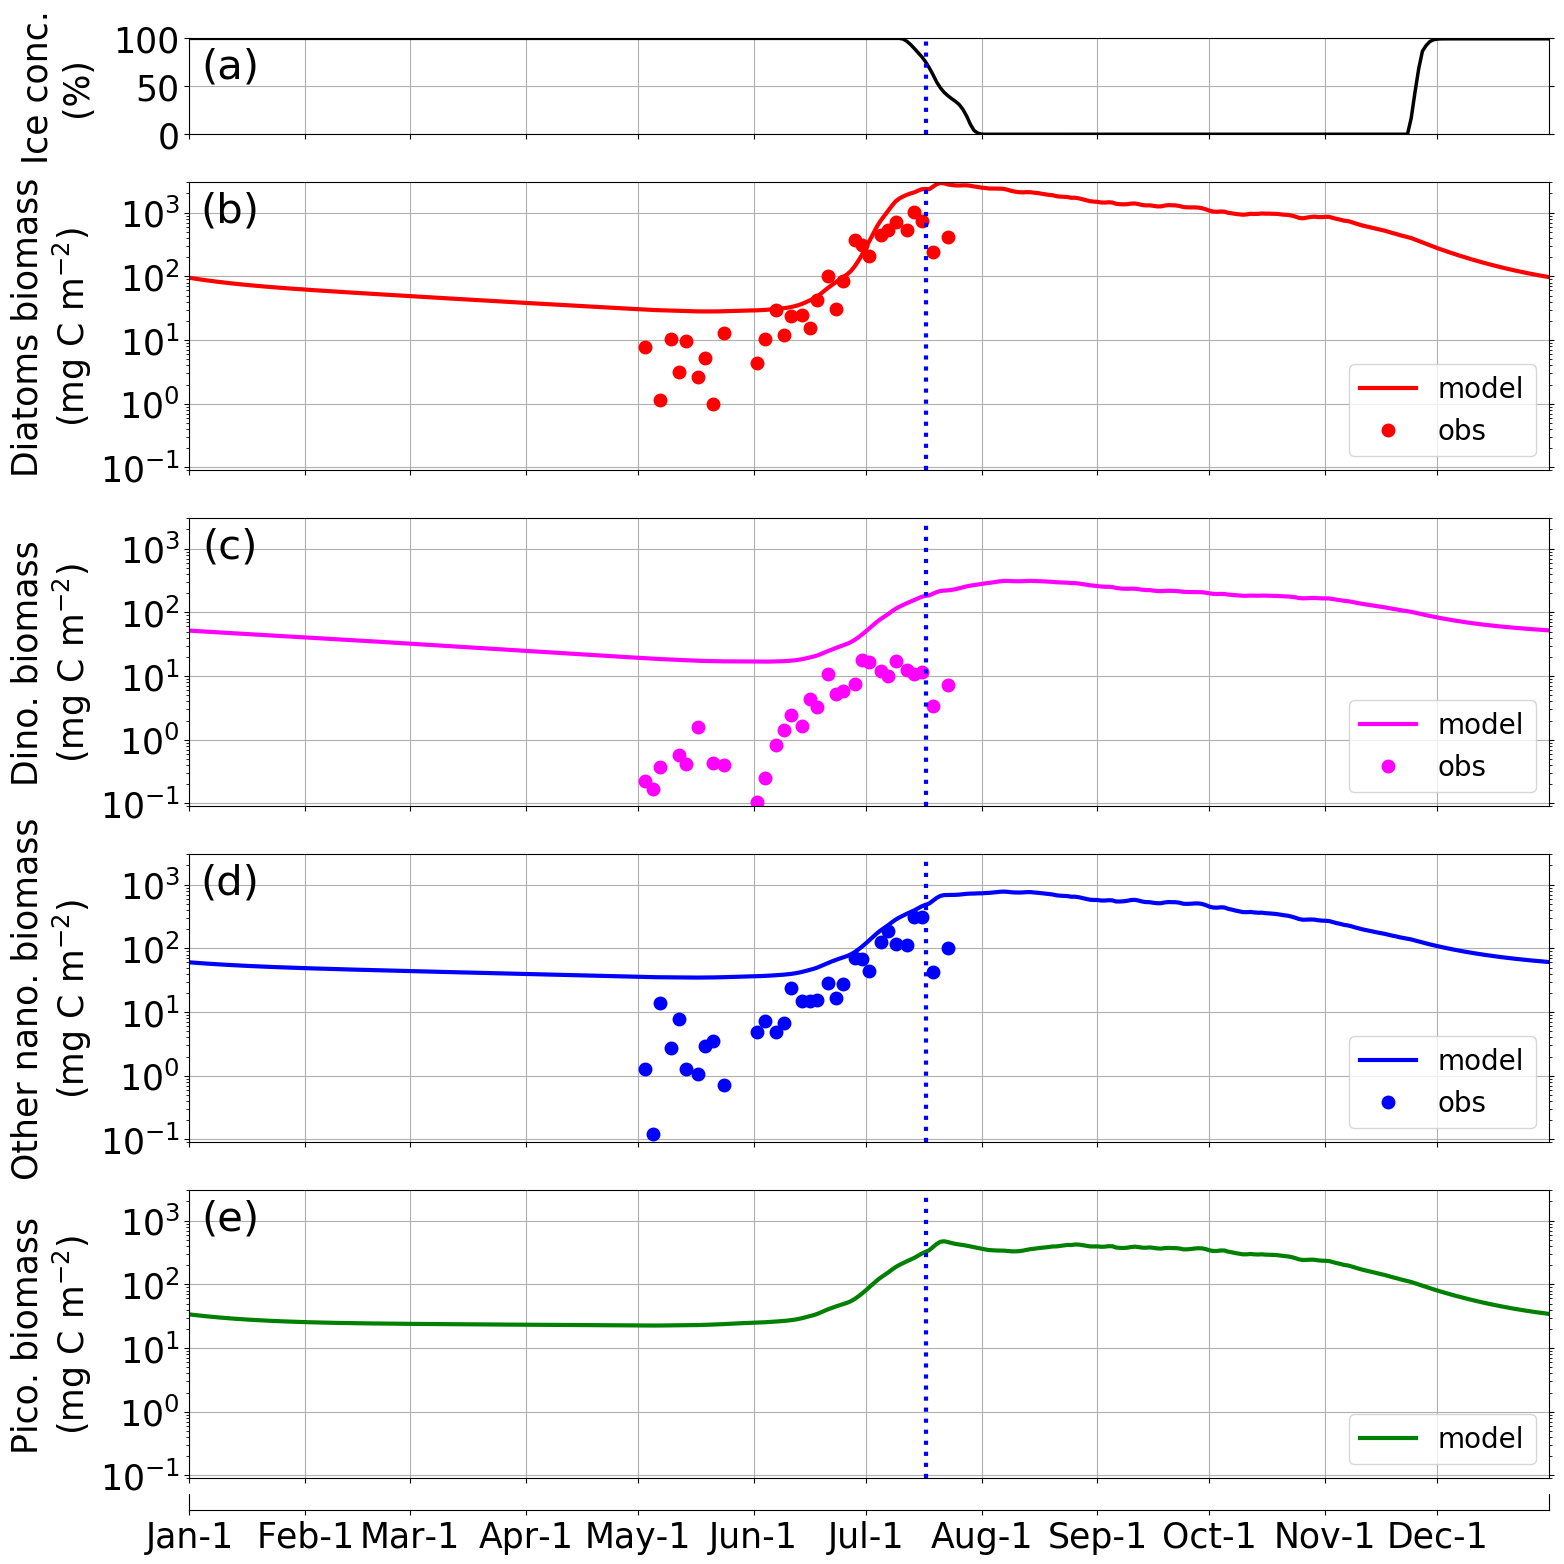

In [191]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n(%)',bbox=box)
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d_iT_simdiatomvint,
               '-',lw=3,color='red',label='model')
    h2=ax.plot(first_year,array1d_iT_obsdiatomvint,
               'o',color='red',label='obs')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Diatoms biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[2]
    h1=ax.plot(first_year,array1d_iT_simdinovint,
               '-',lw=3,color='magenta',label='model')
    h2=ax.plot(first_year,array1d_iT_obsdinovint,
               'o',color='magenta',label='obs')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Dino. biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER NANOEUKARYOTES
    ax=axs[3]
    h1=ax.plot(first_year,array1d_iT_simothervint,
               '-',lw=3,color='blue',label='model')
    h2=ax.plot(first_year,array1d_iT_obsothervint,
               'o',color='blue',label='obs')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Other nano. biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- PICOPHYTOPLANKTON
    ax=axs[4]
    h1=ax.plot(first_year,array1d_iT_simpicovint,
               '-',lw=3,color='green',label='model')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Pico. biomass\n($\mathrm{ mg\ C\ m^{-2} }$)',bbox=box)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(9E-2,3E3)
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.03,0.90,'(e)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[5]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.92  ,0.85,0.06])
    axs[1].set_position( [0.12,0.71  ,0.85,0.18])
    axs[2].set_position( [0.12,0.50  ,0.85,0.18])
    axs[3].set_position( [0.12,0.29  ,0.85,0.18])
    axs[4].set_position( [0.12,0.08  ,0.85,0.18])
    axs[5].set_position( [0.12,0.06  ,0.85,0.01])

with plt.style.context('many_rows_one_col.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(6,1,sharex=False,figsize=(16, 16))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.groups.vint100m.png')

In [192]:
plt.close('all')

## Comparison between observations and simulation: relative contribution ($\%$)

The relative contribution for validation purposes was calculated as a percentage of the biogeochemical functional group biomass vertically integrated (0-100m)  from all the nanoeukaryotes and microeukaryotes biomass.

In [193]:
# See the answer from Divakar on
# https://stackoverflow.com/questions/33269369/adding-two-2d-numpy-arrays-ignoring-nans-in-them
array1d_iT_obsvint=np.nansum(np.dstack((array1d_iT_obsdiatomvint,
                                        array1d_iT_obsdinovint,
                                        array1d_iT_obsothervint)),
                             2).flatten()
array1d_iT_simvint=array1d_iT_simdiatomvint+array1d_iT_simdinovint \
+array1d_iT_simothervint

In [194]:
array1d1d_iT_obsdiatomperc =array1d_iT_obsdiatomvint /array1d_iT_obsvint*100
array1d1d_iT_obsdinoperc   =array1d_iT_obsdinovint   /array1d_iT_obsvint*100
array1d1d_iT_obsotherperc  =array1d_iT_obsothervint  /array1d_iT_obsvint*100

In [195]:
array1d1d_iT_simdiatomperc =array1d_iT_simdiatomvint/array1d_iT_simvint*100
array1d1d_iT_simdinoperc   =array1d_iT_simdinovint  /array1d_iT_simvint*100
array1d1d_iT_simotherperc  =array1d_iT_simothervint /array1d_iT_simvint*100

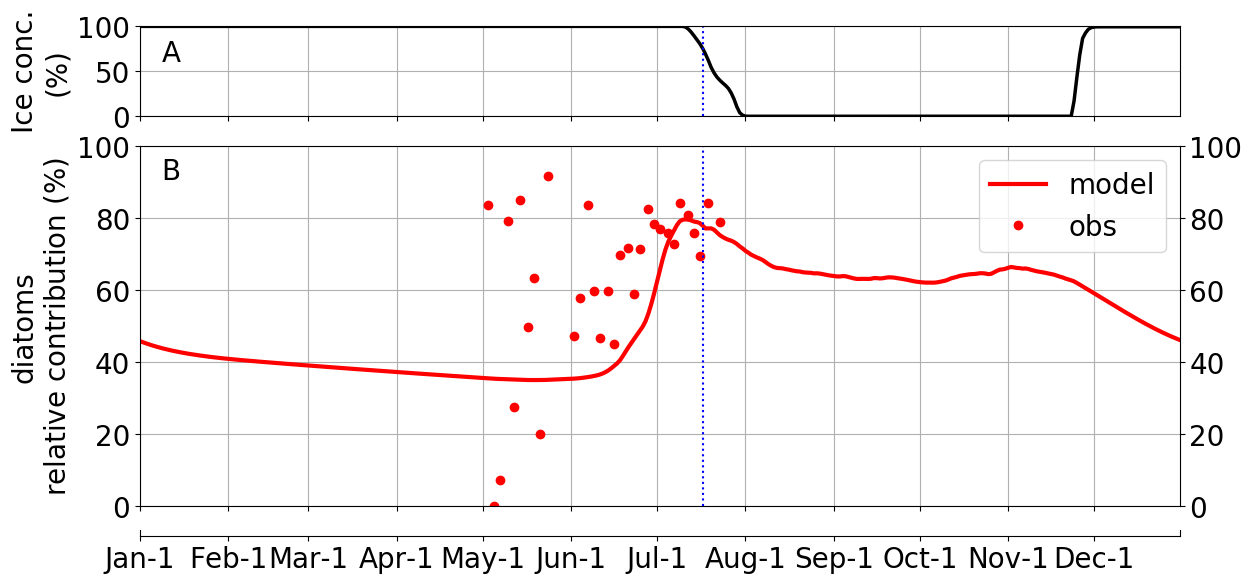

In [196]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d1d_iT_simdiatomperc,
               '-',lw=3,color='red',label='model')
    h2=ax.plot(first_year,array1d1d_iT_obsdiatomperc,
               'o',color='red',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('diatoms\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.diatoms.percentage.png')

In [197]:
plt.close('all')

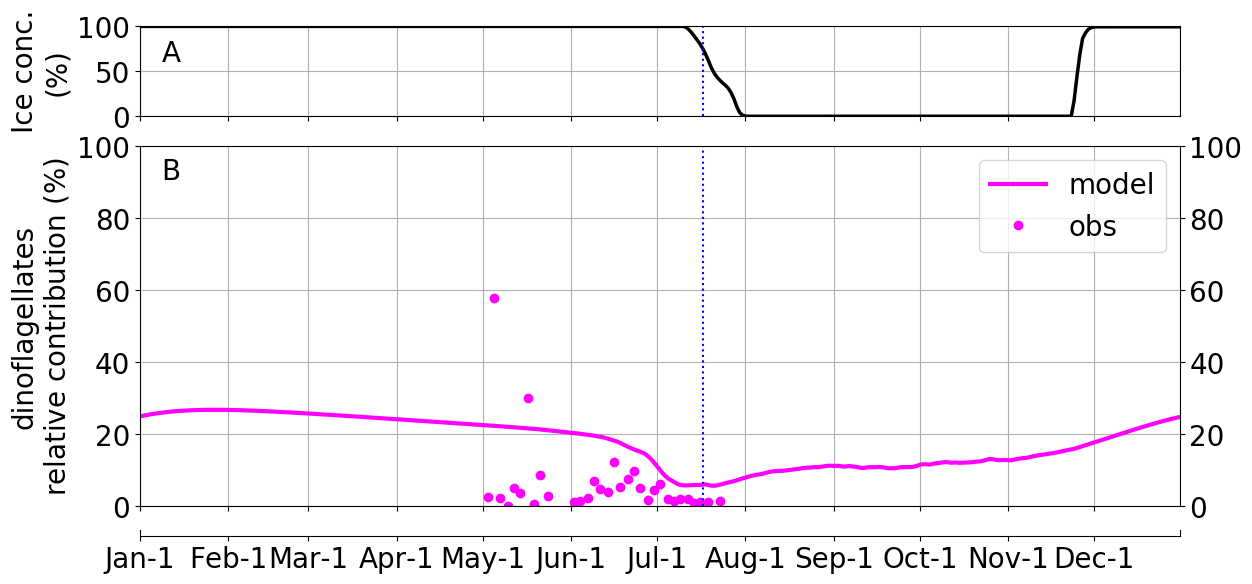

In [198]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[1]
    h1=ax.plot(first_year,array1d1d_iT_simdinoperc,
               '-',lw=3,color='magenta',label='model')
    h2=ax.plot(first_year,array1d1d_iT_obsdinoperc,
               'o',color='magenta',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('dinoflagellates\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.dino.percentage.png')

In [199]:
plt.close('all')

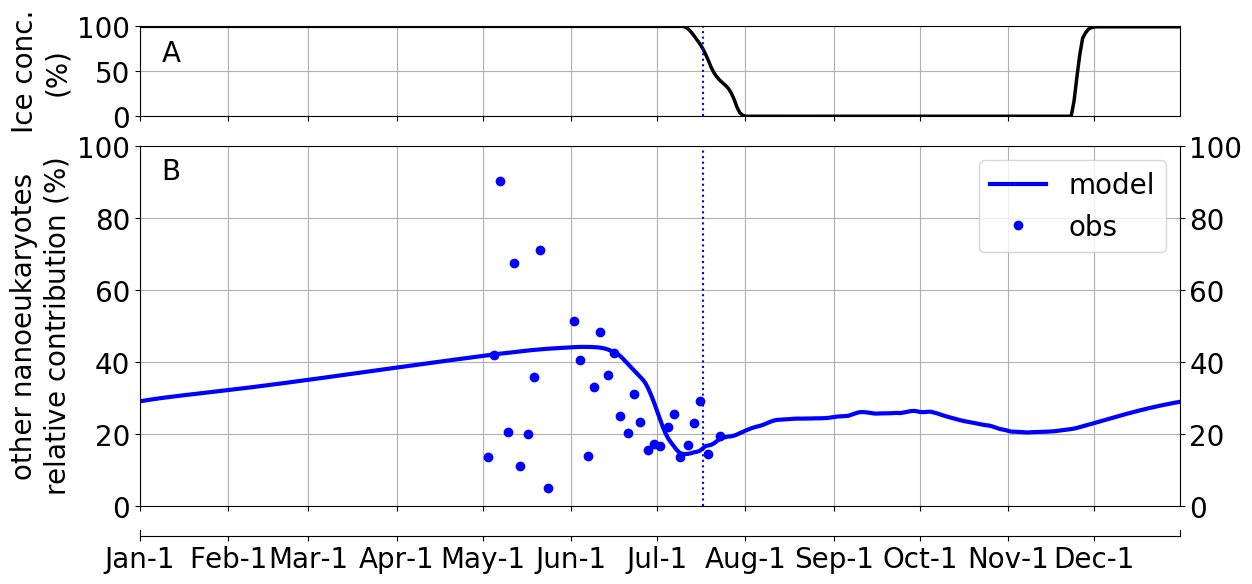

In [200]:
with plt.style.context('ice.mplstyle'):
    locs=np.array([0, 31, 59, 90, 120, 151,
                  181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    fig,axs=plt.subplots(3,1,sharex=False,figsize=(16, 6))

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'A',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER EUKARYOTES
    ax=axs[1]
    h1=ax.plot(first_year,array1d1d_iT_simotherperc,
               '-',lw=3,color='blue',label='model')
    h2=ax.plot(first_year,array1d1d_iT_obsotherperc,
               'o',color='blue',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('other nanoeukaryotes\nrelative contribution ($\%$)')
    ax.yaxis.tick_right()
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.93,'B',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=20)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.80  ,0.65,.15])
    axs[1].set_position( [0.12,0.15  ,0.65,.60])
    axs[2].set_position( [0.12,0.10  ,0.65,.01])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.other.percentage.png')

In [201]:
plt.close('all')

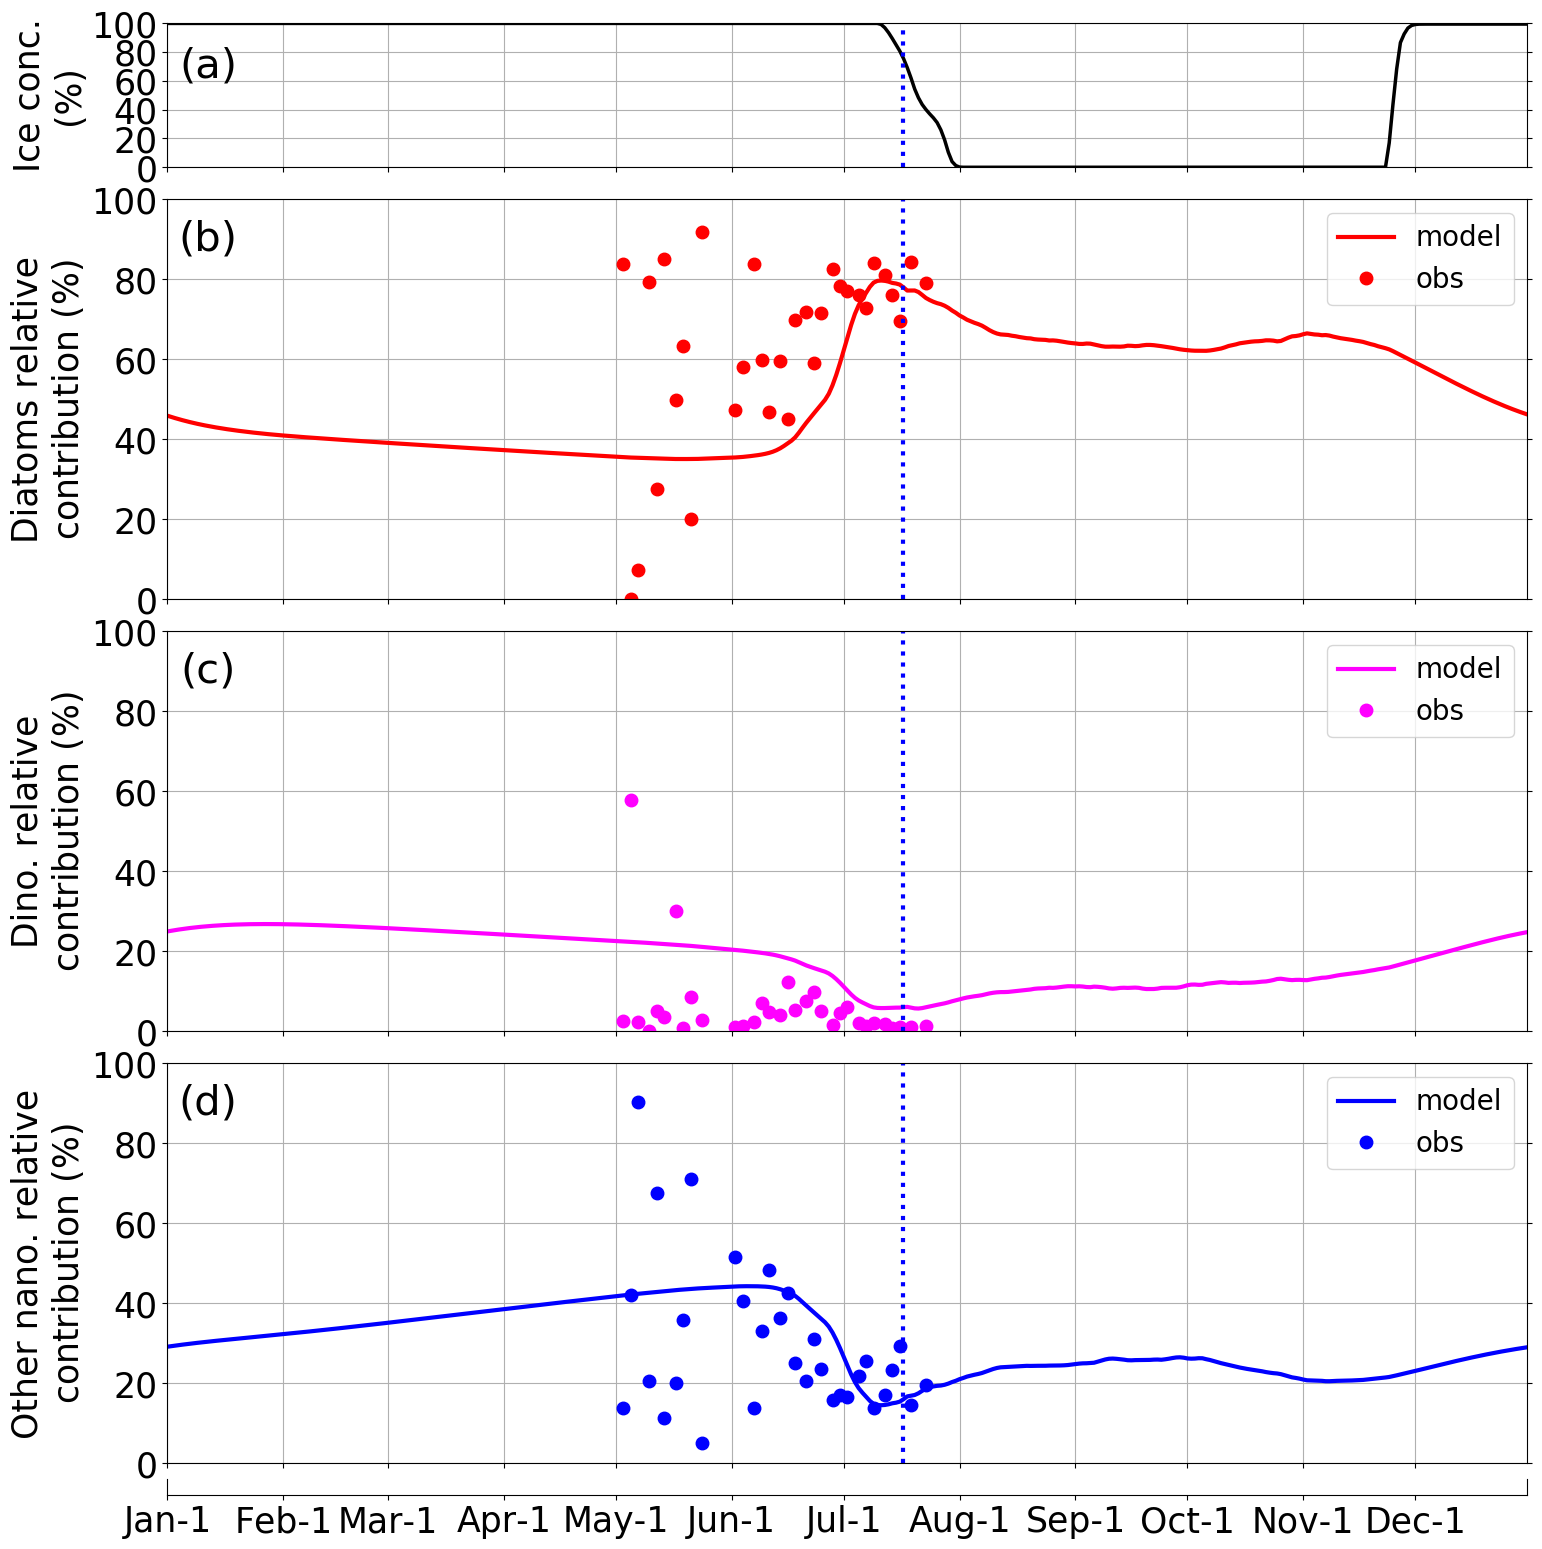

In [202]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')

    # --- ICE CONCENTRATIONS
    ax=axs[0]
    ax.plot(first_year,ice*100,'k-',lw=2.5)
    ax.set_xlim(first_year[0],first_year[-1])
    xlims=ax.get_xlim()
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Ice conc.\n(%)')
    ax.set_ylim(0,100)
    ax.grid()
    plt.text(0.03,0.7,'(a)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DIATOMS
    ax=axs[1]
    h1=ax.plot(first_year,array1d1d_iT_simdiatomperc,
               '-',lw=3,color='red',label='model')
    h2=ax.plot(first_year,array1d1d_iT_obsdiatomperc,
               'o',color='red',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Diatoms relative\ncontribution ($\%$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(b)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- DINOFLAGELLATES
    ax=axs[2]
    h1=ax.plot(first_year,array1d1d_iT_simdinoperc,
               '-',lw=3,color='magenta',label='model')
    h2=ax.plot(first_year,array1d1d_iT_obsdinoperc,
               'o',color='magenta',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Dino. relative\ncontribution ($\%$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(c)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- OTHER EUKARYOTES
    ax=axs[3]
    h1=ax.plot(first_year,array1d1d_iT_simotherperc,
               '-',lw=3,color='blue',label='model')
    h2=ax.plot(first_year,array1d1d_iT_obsotherperc,
               'o',color='blue',label='obs')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('Other nano. relative\ncontribution ($\%$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(0,100)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.03,0.90,'(d)',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    # adding a vertical line at the bloom peak
    ax.axvline(date_peak,color='b',linestyle=':')
    # adding the vertical line at 15% of observed ice
    # ax.axvline(iT15_start_obs,color='k',linestyle='--')

    # --- ADDITIONAL X-AXIS
    ax=axs[4]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.89  ,0.85,0.09])
    axs[1].set_position( [0.12,0.62  ,0.85,0.25])
    axs[2].set_position( [0.12,0.35  ,0.85,0.25])
    axs[3].set_position( [0.12,0.08  ,0.85,0.25])
    axs[4].set_position( [0.12,0.06  ,0.85,0.01])

with plt.style.context('many_rows_one_col.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(5,1,sharex=False,figsize=(16, 16))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    plt.savefig('validation/GEic2016.comp.groups.percentage.png')

In [203]:
plt.close('all')

# Taylor diagram

## Taylor diagram: on all the observations (in $mg\ C\ m^{-3}$)

In [204]:
array1d_iobs_logobsdiatoms=np.log10(diatomsobs_df['carbon_estimate_mg_c_m3'])
array1d_iobs_logsimdiatom =np.log10(simdiatom_df['carbon_estimate_mg_c_m3'])
refnstd=np.nanstd(array1d_iobs_logobsdiatoms,ddof=1) \
/np.nanstd(array1d_iobs_logobsdiatoms,ddof=1)
nstdlogdiatom=np.nanstd(array1d_iobs_logsimdiatom,ddof=1) \
/np.nanstd(array1d_iobs_logobsdiatoms,ddof=1)
corrcoeflogdiatom=(pd.DataFrame(
    {'array1d_iobs_logobsdiatoms':array1d_iobs_logobsdiatoms,
    'array1d_iobs_logsimdiatom':array1d_iobs_logsimdiatom}) \
          .corr()).iloc[0,1]

In [205]:
array1d_iobs_logobsdino=np.log10(dinoobs_df['carbon_estimate_mg_c_m3'])
array1d_iobs_logsimdino =np.log10(simdino_df['carbon_estimate_mg_c_m3'])
refnstd=np.nanstd(array1d_iobs_logobsdino,ddof=1) \
/np.nanstd(array1d_iobs_logobsdino,ddof=1)
nstdlogdino=np.nanstd(array1d_iobs_logsimdino,ddof=1) \
/np.nanstd(array1d_iobs_logobsdino,ddof=1)
corrcoeflogdino=(pd.DataFrame(
    {'array1d_iobs_logobsdino':array1d_iobs_logobsdino,
    'array1d_iobs_logsimdino':array1d_iobs_logsimdino}) \
          .corr()).iloc[0,1]

In [206]:
array1d_iobs_logobsother=np.log10(otherobs_df['carbon_estimate_mg_c_m3'])
array1d_iobs_logsimother =np.log10(simother_df['carbon_estimate_mg_c_m3'])
refnstd=np.nanstd(array1d_iobs_logobsother,ddof=1) \
/np.nanstd(array1d_iobs_logobsother,ddof=1)
nstdlogother=np.nanstd(array1d_iobs_logsimother,ddof=1) \
/np.nanstd(array1d_iobs_logobsother,ddof=1)
corrcoeflogother=(pd.DataFrame(
    {'array1d_iobs_logobsother':array1d_iobs_logobsother,
    'array1d_iobs_logsimother':array1d_iobs_logsimother}) \
          .corr()).iloc[0,1]

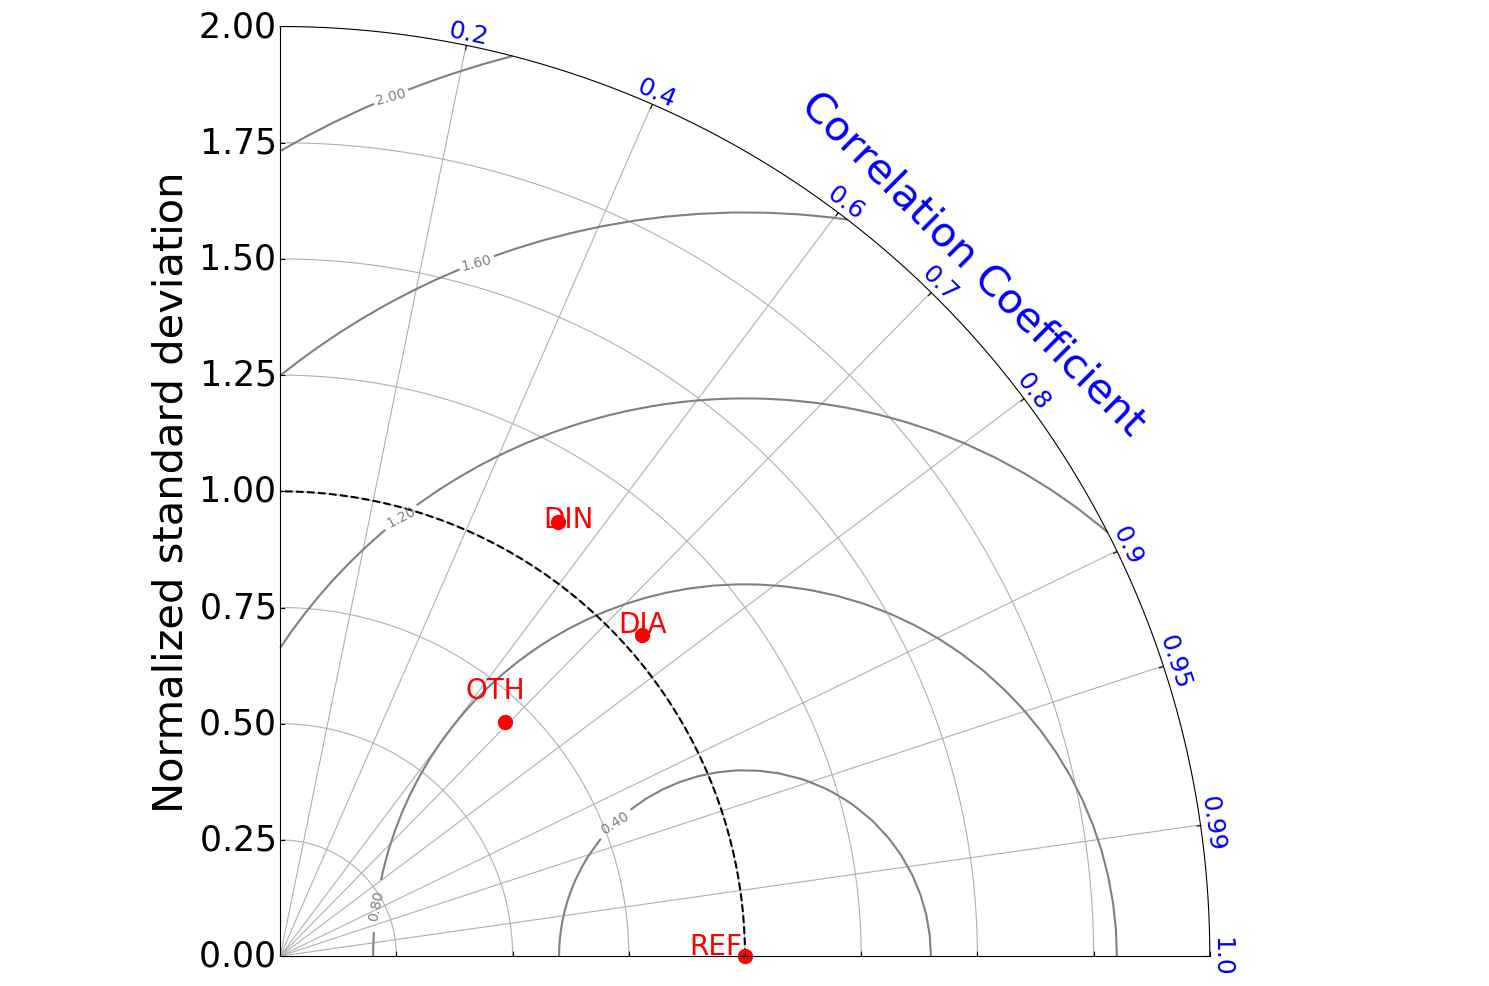

In [207]:
with plt.style.context('noice.mplstyle'):
    fig=plt.figure(figsize=(15,10))
    ax=plt.gca()
    plt.axis('off')
    dia=TaylorDiagramMBG.TaylorDiagram(refnstd,
                                       fig=fig,
                                       rect=111,
                                       label='Reference',
                                       srange=(0,2),
                                       extend=False)
    dia.add_sample(nstdlogdiatom,
                   corrcoeflogdiatom,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red',
                   label='DIA')
    dia.add_sample(nstdlogdino,
                   corrcoeflogdino,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red',
                   label='DIN')
    dia.add_sample(nstdlogother,
                   corrcoeflogother,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red',
                   label='OTH')
    dia.add_grid()
    contours=dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    plt.text(0.43,0.36,'DIA',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.38,0.47,'DIN',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.33,0.29,'OTH',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.48,0.02,'REF',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.tight_layout()
    plt.savefig('validation/GEic2016.taylor.groups.m3.log.png')

In [208]:
plt.close('all')